# スケジューリング最適化システム OptSeq

>  Scheduling Solver OptSeq 

ドキュメント

> https://mikiokubo.github.io/scmopt/07optseq/


OptSeq（オプトシーク）は，スケジューリング問題に特化した最適化ソルバーである．
スケジューリング問題は，通常の混合整数最適化ソルバーが苦手とするタイプの問題であり，
実務における複雑な条件が付加されたスケジューリング問題に対しては，専用の解法が必要となる．
OptSeqは，スケジューリング問題に特化した**メタヒューリスティクス**(metaheuristics)を用いることによって，
大規模な問題に対しても短時間で良好な解を探索することができるように設計されている．

このモジュールは， すべてPythonで書かれたクラスで構成されている．
OptSeqのトライアルバージョンは， http://logopt.com/optseq/ からダウンロードできる．

In [ ]:
#default_exp optseq

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import sys
import re
import copy
import platform
import string
_trans = str.maketrans("-+*/'(){}^=<>$ #?,¥", "_"*19) #文字列変換用
import pandas as pd
import ast
import pickle
import numpy as np

import base64
from io import BytesIO

import plotly.graph_objs as go
import plotly

from collections import Counter
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import datetime as dt
from IPython.display import Image, YouTubeVideo
folder = "data/optseq/"

## 簡易システムの紹介ビデオ

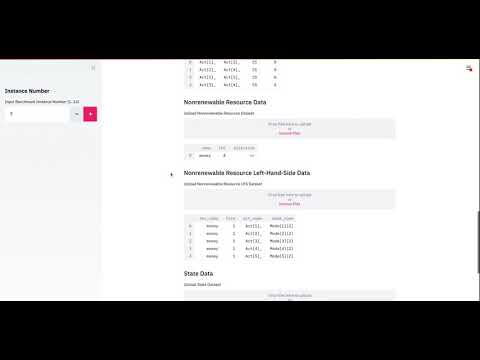

In [ ]:
YouTubeVideo("Nue61nhu9PE")

### OptSeqモジュールの基本クラス

行うべき仕事（ジョブ，作業，タスク）を**作業**(activity；活動)とよぶ． スケジューリング問題の目的は作業をどのようにして時間軸上に並べて遂行するかを決めることであるが，
ここで対象とする問題では作業を処理するための方法が何通りかあって，そのうち1つを選択することによって
処理するものとする．このような作業の処理方法を**モード**(mode)とよぶ．

納期や納期遅れのペナルティ（重み）は作業ごとに定めるが，
作業時間や資源の使用量はモードごとに決めることができる．

作業を遂行するためには**資源**(resource)を必要とする場合がある．
資源の使用可能量は時刻ごとに変化しても良いものとする．
また，モードごとに定める資源の使用量も作業開始からの経過時間によって変化しても良いものとする．
通常，資源は作業完了後には再び使用可能になるものと仮定するが，
お金や原材料のように一度使用するとなくなってしまうものも考えられる．
そのような資源を**再生不能資源**(nonrenewable resource)とよぶ．

作業間に定義される**時間制約**(time constraint)は，
ある作業（先行作業）の処理が終了するまで，別の作業（後続作業）の処理が開始できないことを表す
先行制約を一般化したものであり，
先行作業の開始（完了）時刻と後続作業の開始（完了）時刻の
間に以下の制約があることを規定する

> 先行作業の開始（完了）時刻 $+$ 時間ずれ $\leq$ 後続作業の開始（完了）時刻

ここで，時間ずれは任意の整数値であり負の値も許すものとする． この制約によって，作業の同時開始，最早開始時刻，時間枠などの様々な条件を記述することができる．

OptSeqでは，モードを作業時間分の小作業の列と考え，処理の途中中断や並列実行も可能であるとする．その際，中断中の資源使用量や並列作業中の資源使用量も別途定義できるものとする．

また，時刻によって変化させることができる**状態**(state)が準備され，モード開始の状態の制限やモードによる状態の推移を定義できる．



### 注意

OptSeqでは作業，モード，資源名を文字列で区別するため重複した名前を付けることはできない．
なお，使用できる文字列は, 英文字 (a--z, A--Z), 
数字 (0--9), 大括弧 ([ ]),  
アンダーバー (_), および @ に限定される．
また，作業名は source, sink以外， モードは dummy 以外の文字に限定される．

それ以外の文字列はすべてアンダーバー (_)に置き換えられる．

## 最適化の描画関数 plot_optseq

In [ ]:
#export
def plot_optseq(file_name: str = "optseq_output.txt" ):
    with open(file_name) as f:
        out = f.readlines()
    x, y = [],[]
    for l in out[9:]: 
        sep = re.split("[=()/]", l)
        if sep[0] != 'objective value ':
            break
        val, cpu = map(float, [ sep[1], sep[3]] )
        x.append(cpu)
        y.append(val)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
            x = x, 
            y = y,
            mode='markers+lines',
            name= "value",
            marker=dict(
                size=10,
                color= "black")
    ))
    fig.update_layout(title = "OptSeq performance",
                   xaxis_title='CPU time',
                   yaxis_title='Value')
    return fig

In [ ]:
fig = plot_optseq()
plotly.offline.plot(fig);

## Parameter クラス

OptSeqを制御するためのパラメータを格納したクラス．

Modelクラスの中で使用される．

OptSeqに内在されている最適化ソルバーの動作は， **パラメータ**(parameter)を変更することによってコントロールできる．
モデルインスタンスmodelのパラメータを変更するときは，以下の書式で行う．


> model.Params.パラメータ名 = 値


代表的なパラメータとその意味を記す．

- RandomSeedは乱数系列の種を設定する．既定値は 1．
- Makespanは最大完了時刻（一番遅く終わる作業の完了時刻）を最小にするときTrueそれ以外のとき （各作業に定義された納期遅れの重みと再生不能資源の逸脱量の重み付き和を最小にするとき）Falseを設定する．
- Neighborhoodは近傍探索を行う際の近傍数を設定するためのパラメータである．
 規定値は20であり，大規模な問題例で求解時間が長い場合には小さい値に設定することが推奨される．
- TimeLimitは最大計算時間 (秒) を設定する． 既定値は 600 秒．
- Initialは，前回最適化の探索を行った際の最良解を初期値とした探索を行うときTrue，それ以外のときFalseを表すパラメータである． 既定値はFalse． 
最良解の情報は作業の順序と選択されたモードとしてファイル名 optseq_best_act_data.txtに保管されている． このファイルを書き換えることによって，異なる初期解から探索を行うことも可能である．
- OutputFlagは計算の途中結果を出力させるためのフラグである．
Trueのとき出力On，Falseのとき出力Off．既定値はFalse．


In [ ]:
#export
class Parameters():
    """
    OptSeq parameter class to control the operation of OptSeq.

    - param  TimeLimit: Limits the total time expended (in seconds). Positive integer. Default=600.

    - param  OutputFlag: Controls the output log. Boolean. Default=False (0).

    - param  RandomSeed: Sets the random seed number. Integer. Default=1.

    - param  ReportInterval: Controls the frequency at which log lines are printed (iteration number). Default=1073741823.

    - param  Backtruck: Controls the maximum backtrucks. Default=1000.

    - param  MaxIteration: Sets the maximum numbers of iterations. Default=1073741823.

    - param  Initial: =True if the user wants to set an initial activity list. Default = False.
            Note that the file name of the activity list must be "optseq_best_act_data.txt."

    - param  Tenure: Controls a parameter of tabu search (initial tabu tenure). Default=0.

    - param  Neighborhood: Controls a parameter of tabu search (neighborhood size). Default=20.

    - param  Makespan: Sets the objective function.
            Makespan is True if the objective is to minimize the makespan (maximum completion time),
            is False otherwise, i.e., to minimize the total weighted tardiness of activities.
            Default=False.
    """

    def __init__(self):
        self.TimeLimit = 600
        self.OutputFlag = 0  # off
        self.RandomSeed = 1
        self.ReportInterval = 1073741823
        self.Backtruck = 1000
        self.MaxIteration = 1073741823
        self.Initial = False
        self.Tenure = 1
        self.Neighborhood = 20
        self.Makespan = False

### Parametesクラスの使用例

In [ ]:
params = Parameters()
params.Makespan = True 
print("maximum iterations = ", params.MaxIteration)

maximum iterations =  1073741823


## Mode クラス

optSeqでは， 作業の処理方法を**モード**(mode)とよぶ．
Modeは作業(Activity)の遂行方法を定義するためのクラスである．
作業は少なくとも1つのモードをもち，そのうちのいずれかを選択して処理される．

モードのインスタンスは，モードクラスModeから生成される．

> モードインスタンス = Mode(name, duration=0)

コンストラクタの引数の名前と意味は以下の通り．
- nameはモードの名前を文字列で与える．ただしモードの名前に'dummy'を用いることはできない．
- durationはモードの作業時間を非負の整数で与える．既定値は $0$．
 
モードインスタンスは，以下のメソッドをもつ．

- addResourceはモードを実行するときに必要な資源とその量を指定する．

  > モードインスタンス.addResource(resource, requirement={}, rtype = None)
  
  引数と意味は以下の通り．
  - resourceは追加する資源インスタンスを与える．
  - requirementは資源の必要量を辞書もしくは正数値で与える．
   辞書のキーはタプル (開始時刻,終了時刻) であり， 値は資源の使用量を表す正数値である．
   正数値で与えた場合には，開始時刻は $0$， 終了時刻は無限大と設定される．

   **注：**作業時間が $0$ のモードに資源を追加することはできない．その場合には実行不可能解と判断される．
   
  - rtypeは資源のタイプを表す文字列． None, 'break', 'max' のいずれかから選択する（既定値は通常の資源を表すNone）．
   'break'を与えた場合には，中断中に使用する資源量を指定する．
    'max'を与えた場合には，並列処理中に使用する資源の「最大量」を指定する． 
   省略可で，その場合には通常の資源使用量を表し，並列処理中には資源使用量の「総和」を使用することになる．
     
- addBreakは中断追加メソッドである． 
  モードは単位時間ごとに分解された作業時間分の小作業の列と考えられる．
  小作業を途中で中断してしばらく時間をおいてから次の小作業を開始することを**中断**(break)とよぶ． 
  中断追加メソッド(addBreak)は，モード実行時における中断の情報を指定する．
 
  > モードインスタンス.addBreak(start=0, finish=0, maxtime='inf')

  引数と意味は以下の通り．
  - startは中断可能な最早時刻を与える．省略可で，既定値は $0$．
  - finishは中断可能時刻の最遅時刻を与える．省略可で，既定値は $0$． 
  - maxtimeは最大中断可能時間を与える．省略可で，既定値は無限大（'inf')．
 
 
- addParallelは並列追加メソッドである．
  モードは単位時間ごとに分解された作業時間分の小作業の列と考えられる．
  資源量に余裕があるなら，同じ時刻に複数の小作業を実行することを**並列実行**(parallel execution)とよぶ．

  並列追加メソッドaddParallel)は，モード実行時における並列実行に関する情報を指定する．

  > モードインスタンス.addParallel(start=1, finish=1, maxparallel='inf')
  
  引数と意味は以下の通り．
  - startは並列実行可能な最小の小作業番号を与える．省略可で，既定値は $1$．
  - finishは並列実行可能な最大の小作業番号を与える．省略可で，既定値は $1$．
  - maxparallelは同時に並列実行可能な最大数を与える．省略可で，既定値は無限大('inf')．
 
  
- addStateは状態追加メソッドである．
  状態追加メソッド(addState)は，モード実行時における状態の値と実行直後（実行開始が時刻 $t$ のときには，時刻 $t+1$）の
  状態の値を定義する．
  
   
   > モードインスタンス.addState(state, fromValue=0, toValue=0)
   
   
   引数と意味は以下の通り  
   - stateはモードに付随する状態インスタンスを与える．省略不可．
   - fromValueはモード実行時における状態の値を与える．省略可で，既定値は $0$． 
   - toValueはモード実行直後における状態の値を与える．省略可で，既定値は $0$．
 
モードインスタンスは以下の属性をもつ．

- nameはモード名である．
- durationはモードの作業時間である．
- requirementははモードの実行の資源・資源タイプと必要量を表す辞書である．
キーは資源名と資源タイプ（None:通常， ’break’:中断中， ’max’:並列作業中の最大資源量）のタプルであり，
値は資源必要量を表す辞書である．この辞書のキーはタプル（開始時刻，終了時刻）であり，値は資源の使用量を表す正数値である．

- breakableは中断の情報を表す辞書である．
辞書のキーはタプル（開始時刻，終了時刻）であり，値は中断可能時間を表す正数値である．

- parallelは並列作業の情報を表す辞書である．辞書のキーはタプル(開始小作業番号,終了小作業番号)であり，
値は最大並列可能数を表す正数値である．
  
- autoselectはモードを自動選択するときTrue，それ以外のときFalseを設定する．
   既定値はFalseであり，状態によってモードの開始が制限されている場合には， autoselectをTrueに設定しておくことが推奨される．


In [ ]:
#export
class Mode():
    """
    OptSeq mode class.

        - Arguments:
            - name: Name of mode (sub-activity).
                    Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.
                    Also you cannot use "dummy" for the name of a mode.
                    - duration(optional): Processing time of mode. Default=0.

        - Attbibutes:
            - requirement: Dictionary that maps a pair of resource name and resource type (rtype) to requirement dictionary.
                    Requirement dictionary maps intervals (pairs of start time and finish time) to amounts of requirement.
                    Resource type (rtype) is None (standard resource type), "break" or "max."
            - breakable: Dictionary that maps breakable intervals to maximum brek times.
            - paralel:  Dictionary that maps parallelable intervals to maximum parallel numbers.
            - state: Dictionary that maps states to the tuples of values.
     """

    def __init__(self, name="", duration=0):

        if name == "dummy":
            print("source and sink cannnot be used as an activity name")
            raise NameError
        self.name = str(name).translate(_trans)
        self.duration = duration
        self.requirement = {}
        self.breakable = {}
        self.parallel = {}
        self.state = {}

    def __str__(self):
        ret = [" duration {0} ".format(self.duration)]

        if self.requirement:
            for (r, rtype) in self.requirement:
                for (interval, cap) in self.requirement[(r, rtype)].items():
                    (s, t) = interval
                    if rtype == "max":
                        ret.append(
                            " {0} max interval {1} {2} requirement {3} ".format(r, s, t, cap))
                    elif rtype == "break":
                        ret.append(
                            " {0} interval break {1} {2} requirement {3} ".format(r, s, t, cap))
                    elif rtype == None:
                        ret.append(
                            " {0} interval {1} {2} requirement {3} ".format(r, s, t, cap))
                    else:
                        print("resource type error")
                        raise TypeError

        # break
        if self.breakable:
            for (interval, cap) in self.breakable.items():
                (s, t) = interval
                if cap == "inf":
                    ret.append(" break interval {0} {1} ".format(s, t))
                else:
                    ret.append(
                        " break interval {0} {1} max {2} ".format(s, t, cap))

        # parallel
        if self.parallel:
            for (interval, cap) in self.parallel.items():
                (s, t) = interval
                if cap == "inf":
                    ret.append(" parallel interval {0} {1} ".format(s, t))
                else:
                    ret.append(
                        " parallel interval {0} {1} max {2} ".format(s, t, cap))

        # state
        if self.state:
            for s in self.state:
                for (f, t) in self.state[s]:
                    ret.append(" {0} from {1} to {2} ".format(s, f, t))

        return " \n".join(ret)

    def addState(self, state, fromValue=0, toValue=0):
        """
        Adds a state change information to the mode.

            - Arguments:
                - state: State object to be added to the mode.
                - fromValue: the value from which the state changes by the mode
                - toValue:  the value to which the state changes by the mode

            - Example usage:

            >>> mode.addState(state1,0,1)

            defines that state1 is changed from 0 to 1.

        """
        if type(fromValue) != type(1) or type(toValue) != type(1):
            print(
                "time and value of the state {0} must be integer".format(self.name))
            raise TypeError
        else:
            if state.name not in self.state:
                self.state[state.name] = [(fromValue, toValue)]
            else:
                self.state[state.name].append((fromValue, toValue))

    def addResource(self, resource, requirement=None, rtype=None):
        """
        Adds a resource to the mode.

            - Arguments:
                - resurce: Resource object to be added to the mode.
                - requirement: Dictionary that maps intervals (pairs of start time and finish time) to amounts of requirement.
                               It may be an integer; in this case, requirement is converted into the dictionary {(0,"inf"):requirement}.
                - rtype (optional): Type of resource to be added to the mode.
                None (standard resource type; default), "break" or "max."

            - Example usage:

            >>> mode.addResource(worker,{(0,10):1})

            defines worker resource that uses 1 unit for 10 periods.

            >>> mode.addResource(machine,{(0,"inf"):1},"break")

            defines machine resource that uses 1 unit during break periods.

            >>> mode.addResource(machine,{(0,"inf"):1},"max")

            defines machine resource that uses 1 unit during parallel execution.
        """
        if requirement == None:
            requirement = {}
        if type(requirement) == type(1):
            requirement = {(0, "inf"): requirement}

        if type(resource.name) != type("") or type(requirement) != type({}):
            print("type error in adding a resource {0} to activity".format(
                resource.name, self.name))
            raise TypeError
        elif rtype == None or rtype == "break" or rtype == "max":
            if (resource.name, rtype) not in self.requirement:
                # generate an empty dic.
                self.requirement[(resource.name, rtype)] = {}
            data = copy.deepcopy(self.requirement[(resource.name, rtype)])
            data.update(requirement)
            self.requirement[(resource.name, rtype)] = data
        else:
            print("rtype must be None or break or max")
            raise NameError

    def addBreak(self, start=0, finish=0, maxtime="inf"):
        """
        Sets breakable information to the mode.

            - Arguments:
                - start(optional): Earliest break time. Non-negative integer. Default=0.
                - finish(optional): Latest break time.  Non-negative integer or "inf." Default=0.
                    Interval (start,finish) defines a possible break interval.
                - maxtime(optional): Maximum break time. Non-negative integer or "inf." Default="inf."

            - Example usage:

            >>> mode.addBreak(0,10,1)

            defines a break between (0,10) for one period.
        """
        data = copy.deepcopy(self.breakable)
        data.update({(start, finish): maxtime})
        self.breakable = data

    def addParallel(self, start=1, finish=1, maxparallel="inf"):
        """
        Sets parallel information to the mode.

            - Arguments:
                - start(optional): Smallest job index executable in parallel. Positive integer. Default=1.
                - finish(optional): Largest job index executable in parallel. Positive integer or "inf." Default=1.
                - maxparallel(optional): Maximum job numbers executable in parallel. Non-negative integer or "inf." Default="inf."

            - Example usage:

            >>> mode.addParallel(1,1,2)
        """
        data = copy.deepcopy(self.parallel)
        data.update({(start, finish): maxparallel})
        self.parallel = data

### Modeクラスの使用例


In [ ]:
mode = Mode("test mode")
mode.addBreak(0,10,1)
mode.addParallel(1,1,2)
print(mode)

 duration 0  
 break interval 0 10 max 1  
 parallel interval 1 1 max 2 


## Activity クラス

成すべき仕事（ジョブ，活動，タスク）を総称して**作業**(activity)とよぶ．

Acticityは作業を定義するためのクラスである．

作業クラスのインスタンスは，モデルインスタンスmodelの作業追加メソッド(addActivity)の返値として生成される．

> 作業インスタンス=model.addActivity(name, duedate='inf', weight=1）

作業には任意の数のモード（作業の実行方法）を追加することができる．
モードの追加は，addModesメソッドで行う．

> 作業インスタンス.addModes(モードインスタンス1, モードインスタンス2, ... ) 

作業の情報は，作業インスタンスの属性に保管されている．
作業インスタンスは以下の属性をもつ．

- nameは作業名である．
- duedateは作業の納期であり，$0$ 以上の整数もしく無限大'inf'を入力する．
- backwardは作業を後ろ詰め（バックワード）で最適化するときTrue，それ以外の場合（前詰め；フォワード；既定値）Falseを入力する． 
ただし，後ろ詰めを指定した場合には，状態変数は機能しない．また，納期 (duedate) は無限大 'inf'以外であるか、後続作業に 'inf' 以外の納期が設定されている必要がある．
また，前詰めと後ろ詰めの混合も可能であるが，後ろ詰めを指定した作業の後続作業も「自動的に」後ろ詰めに変更される．
後ろ詰めの場合の納期は**絶対条件**として処理されるので，後続作業の含めて実行不能にならないように設定する必要がある．

- weightは作業の完了時刻が納期を遅れたときの単位時間あたりのペナルティである．
- modesは作業に付随するモードインスタンスのリストを保持する．   
- selectedは探索によって発見された解において選択されたモードインスタンスを保持する．
- startは探索によって発見された解における作業の開始時刻である．
- completionは探索によって発見された解における作業の終了時刻である．
- executeは探索によって発見された解における作業の実行を表す辞書である．キーは作業の開始時刻と終了時刻のタプル，
値は並列実行数を表す正数値である．



In [ ]:
#export
class Activity():
    """
    OptSeq activity class.

        You can create an activity object by adding an activity to a model (using Model.addActivity)
        instead of by using an Activity constructor.

        - Arguments:
                - name: Name of activity. Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.
                        Also you cannot use "source" and "sink" for the name of an activity.
                - duedate(optional): Duedate of activity. A non-nagative integer or string "inf."
                - backward(optional): True if activity is distached backwardly, False (default) otherwise.
                - weight(optional): Panalty of one unit of tardiness. Positive integer.
                - autoselect(optional): True or False flag that indicates the activity selects the mode automatically or not.
    """

    ID = 0
    def __init__(self, name="", duedate="inf", backward= False, weight=1, autoselect=False):

        if name == "source" or name == "sink":
            print("source and sink cannnot be used as an activity name")
            raise NameError
        if name == "" or name == None:
            name = "__a{0}".format(Activity.ID)
            Activity.ID += 1
        # convert illegal characters into _ (underscore)
        self.name = str(name).translate(_trans)
        self.duedate = duedate
        self.backward = backward  #backward
        self.weight = weight
        self.autoselect = autoselect
        self.modes = []  # list of mode objects
        self.start = 0
        self.completion = 0
        self.execute = {}
        self.selected = None

    def __str__(self):
        ret = ["activity {0}".format(self.name)]
        if self.duedate != "inf":
            if self.backward==True:
                ret.append(" backward duedate {0} ".format(self.duedate))
            else:
                ret.append(" duedate {0} ".format(self.duedate))
            ret.append(" weight {0} ".format(self.weight))
        if len(self.modes) == 1:  # single mode
            # print mode information
            ret.append(" mode {0} ".format(self.modes[0]))
            # ret.append(str(self.modes[0]))
        elif len(self.modes) >= 2:
            if self.autoselect == True:
                ret.append(" autoselect ")
            for m in self.modes:  # multiple modes
                ret.append(" {0} ".format(m.name))  # print mode names
            # ret+="\n"
        else:
            ret.append(" no mode ")
        return " \n".join(ret)

    def addModes(self, *modes):
        """
        Adds a mode or modes to the activity.

            - Arguments:
                - modes: One or more mode objects.

            - Example usage:

            >>> activity.addModes(mode1,mode2)
        """
        for mode in modes:
            self.modes.append(mode)

### Activityクラスの使用例

In [ ]:
act = Activity("sample activity", duedate=100, backward=True, weight=10)
act.addModes(mode)
print(act)

activity sample_activity 
 backward duedate 100  
 weight 10  
 mode  duration 0  
 break interval 0 10 max 1  
 parallel interval 1 1 max 2  


## Resource クラス

Resourceは資源を定義するためのクラスである．

資源インスタンスは，モデルの資源追加メソッド(addResource)の返値として生成される．

> 資源インスタンス = model.addResource(name, capacity, rhs=0, direction='<=', weight='inf'）

資源インスタンスは，以下のメソッドをもつ．


- addCapacityは資源に容量を追加するためのメソッドであり，資源の容量を追加する．
  
   引数と意味は以下の通り．
   - startは資源容量追加の開始時刻（区間の始まり）を与える．
   - finishは資源容量追加の終了時刻（区間の終わり）を与える． 
   - amountは追加する資源量を与える．
 
- setRhs(rhs)は再生不能資源を表す線形制約の右辺定数をrhsに設定する．引数は整数値（負の値も許すことに注意）とする．


- setDirection(dir)は再生不能資源を表す制約の種類をdirに設定する． 引数のdirは'<=', '>=', '='のいずれかとする．

- addTerms(coeffs,vars,values)は，再生不能資源制約の左辺に1つ，もしくは複数の項を追加するメソッドである． 作業がモードで実行されるときに $1$， それ以外のとき $0$ となる変数（値変数）を x[作業,モード]とすると，  追加される項は，
$
 係数 \times x[作業,モード]  
$
と記述される． addTermsメソッドの引数は以下の通り．

  - coeffsは追加する項の係数もしくは係数リスト．係数もしくは係数リストの要素は整数（負の値も許す）．
  - varsは追加する項の作業インスタンスもしくは作業インスタンスのリスト． リストの場合には，リストcoeffsと同じ長さをもつ必要がある．
  - valuesは追加する項のモードインスタンスもしくはモードインスタンスのリスト． リストの場合には，リストcoeffsと同じ長さをもつ必要がある．
　
 
資源インスタンスは以下の属性をもつ．

- nameは資源名である．
- capacityは資源の容量（使用可能量の上限）を表す辞書である．
   辞書のキーはタプル (開始時刻, 終了時刻) であり，値は容量を表す正数値である．
- rhsは再生不能資源制約の右辺定数である．
- directionは再生不能資源制約の方向を表す．
- termsは再生不能資源制約の左辺を表す項のリストである．各項は (係数,作業インスタンス,モードインスタンス) のタプルである．


In [ ]:
#export
class Resource():
    """
    OptSeq resource class.

         - Arguments:
             - name: Name of resource.
                     Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.
             - capacity (optional): Capacity dictionary of the renewable (standard) resource.
                         Capacity dictionary maps intervals (pairs of start time and finish time) to amounts of capacity.
                         If it is given by a positive integer, it is converted into the dictionay {(0,"inf"):capacity}.
             - rhs (optional): Right-hand-side constant of nonrenewable resource constraint.
             - direction (optional): Rirection (or sense) of nonrenewable resource constraint; "<=" (default) or ">=".
                     - weight (optional): Weight of nonrenewable resource to compute the penalty for violating the constraint. Non-negative integer or "inf" (default).

         - Attbibutes:
             - capacity: Capacity dictionary of the renewable (standard) resource.
             - rhs: Right-hand-side constant of nonrenewable resource constraint.
             - direction: Rirection (or sense) of nonrenewable resource constraint; "<=" (default) or ">=".
             - terms: List of terms in left-hand-side of nonrenewable resource.
                        Each term is a tuple of coeffcient,activity and mode.
             - weight: Weight of nonrenewable resource to compute the penalty for violating the constraint. Non-negative integer or "inf" (default).

     """
    ID = 0

    def __init__(self, name="", capacity=None, rhs=0, direction="<=", weight="inf"):
        if capacity == None:
            capacity = {}
        if name == "" or name == None:
            name = "__r{0}".format(Resource.ID)
            Resource.ID += 1
        # convert illegal characters into _ (underscore)
        self.name = str(name).translate(_trans)

        if type(capacity) == type(1):
            capacity = {(0, "inf"): capacity}

        self.capacity = capacity
        self.rhs = rhs
        self.direction = direction
        self.terms = []
        self.weight = weight
        self.residual = {}

    def __str__(self):
        ret = []
        if self.capacity:
            ret.append("resource {0} ".format(self.name))
            capList = []
            for (interval, cap) in self.capacity.items():
                (s, t) = interval
                capList.append((s, t, cap))
            #capList.sort()
            for (s, t, cap) in capList:
                ret.append(
                    " interval {0} {1} capacity {2} ".format(s, t, cap))
            # ret.append("\n")
        return " \n".join(ret)

    def addCapacity(self, start=0, finish=0, amount=1):
        """
        Adds a capacity to the resource.

            - Arguments:
                - start(optional): Start time. Non-negative integer. Default=0.
                - finish(optional): Finish time. Non-negative integer. Default=0.
                 Interval (start,finish) defines the interval during which the capacity is added.
                - amount(optional): The amount to be added to the capacity. Positive integer. Default=1.

            - Example usage:

            >>> manpower.addCapacity(0,5,2)
        """

        data = copy.deepcopy(self.capacity)
        data.update({(start, finish): amount})
        self.capacity = data

    def printConstraint(self):
        """
            Returns the information of the linear constraint.

            The constraint is expanded and is shown in a readable format.
        """

        f = ["nonrenewable weight {0} ".format(self.weight)]
        if self.direction == ">=" or self.direction == ">":
            for (coeff, var, value) in self.terms:
                f.append(
                    "{0}({1},{2}) ".format(-coeff, var.name, value.name))
            f.append("<={0} \n".format(-self.rhs))
        elif self.direction == "==" or self.direction == "=":
            for (coeff, var, value) in self.terms:
                f.append("{0}({1},{2}) ".format(
                    coeff, var.name, value.name))
            f.append("<={0} \n".format(self.rhs))
            f.append("nonrenewable weight {0} ".format(self.weight))
            for (coeff, var, value) in self.terms:
                f.append(
                    "{0}({1},{2}) ".format(-coeff, var.name, value.name))
            f.append("<={0} \n".format(-self.rhs))
        else:
            for (coeff, var, value) in self.terms:
                f.append("{0}({1},{2}) ".format(
                    coeff, var.name, value.name))
            f.append("<={0} \n".format(self.rhs))

        return "".join(f)

    def addTerms(self, coeffs=None, vars=None, values=None):
        """
        Add new terms into left-hand-side of nonrenewable resource constraint.

            - Arguments:
                - coeffs: Coefficients for new terms; either a list of coefficients or a single coefficient.
                The three arguments must have the same size.
                - vars: Activity objects for new terms; either a list of activity objects or a single activity object.
                The three arguments must have the same size.
                - values: Mode objects for new terms; either a list of mode objects or a single mode object.
                The three arguments must have the same size.

            - Example usage:

            >>> budget.addTerms(1,act,express)

            adds one unit of nonrenewable resource (budget) if activity "act" is executed in mode "express."

        """

        # need a check whether coeffs is numeric ...
        if type(coeffs) != type([]):
            self.terms.append((coeffs, vars, values))
        elif type(coeffs) != type([]) or type(vars) != type([]) or type(values) != type([]):
            print("coeffs, vars, values must be lists")
            raise TypeError
        elif len(coeffs) != len(vars) or len(coeffs) != len(values) or len(values) != len(vars):
            print("length of coeffs, vars, values must be identical")
            raise TypeError
        else:
            for i in range(len(coeffs)):
                self.terms.append((coeffs[i], vars[i], values[i]))

    def setRhs(self, rhs=0):
        """
        Sets the right-hand-side of linear constraint.

            - Argument:
                - rhs: Right-hand-side of linear constraint.

            - Example usage:

            >>> L.setRhs(10)

        """
        self.rhs = rhs

    def setDirection(self, direction="<="):
        if direction in ["<=", ">=", "="]:
            self.direction = direction
        else:
            print(
                "direction setting error; direction should be one of '<=' or '>=' or '='")
            raise NameError

### Resourceクラスの使用例

In [ ]:
res = Resource("sample resource", capacity = 1)
res.addCapacity(0,5,10)
print("renewable resource= \n", res)

res2 = Resource("non-renewable", rhs=1, direction="<=", weight=100 )
res2.addTerms(coeffs=1, vars=act, values=mode)
print( res2.printConstraint() )

renewable resource= 
 resource sample_resource  
 interval 0 inf capacity 1  
 interval 0 5 capacity 10 
nonrenewable weight 100 1(sample_activity,test_mode) <=1 



## Temporal クラス

Temporalは時間制約を定義するためのクラスである．

時間制約インスタンスは，モデルに含まれる形で生成される．
時間制約インスタンスは，上述したモデルの時間制約追加メソッド(addTemporal)の返値として生成される．

> 時間制約インスタンス = model.addTemporal(pred, succ, tempType='CS', delay=0）

時間制約インスタンスは以下の属性をもつ．

- predは先行作業のインスタンスである．
- succは後続作業のインスタンスである．
- typeは時間制約のタイプを表す文字列であり，'SS'（開始，開始）,'SC'（開始，完了）,'CS'（完了，開始）,'CC'（完了，完了）のいずれかを指定する．
- delayは時間制約の時間ずれを表す整数値である．


In [ ]:
#export
class Temporal():
    """
    OptSeq temporal class.

    A temporal constraint has the following form::

        predecessor's completion (start) time +delay <=
                        successor's start (completion) time.

    Parameter "delay" can be negative.

        - Arguments:
            - pred: Predecessor (an activity object) or string "source."
                    Here, "source" specifies a dummy activity that precedes all other activities and starts at time 0.
            - succ: Successor (an activity object) or string "source."
                    Here, "source" specifies a dummy activity that precedes all other activities and starts at time 0.
            - tempType (optional): String that differentiates the temporal type.
                "CS" (default)=Completion-Start, "SS"=Start-Start,
                "SC"= Start-Completion, "CC"=Completion-Completion.
            - delay (optional): Time lag between the completion (start) times of two activities.

        - Attributes:
            - pred: Predecessor (an activity object) or string "source."
            - succ: Successor (an activity object) or string "source."
            - type: String that differentiates the temporal type.
                "CS" (default)=Completion-Start, "SS"=Start-Start,
                "SC"= Start-Completion, "CC"=Completion-Completion.
            - delay: Time lag between the completion (start) times of two activities. default=0.

    """

    def __init__(self, pred, succ, tempType="FS", delay=0):

        self.pred = pred
        self.succ = succ
        self.type = tempType
        self.delay = delay

    def __str__(self):
        if self.pred == "source":
            pred = "source"
        elif self.pred == "sink":
            pred = "sink"
        else:
            pred = str(self.pred.name)

        if self.succ == "source":
            succ = "source"
        elif self.succ == "sink":
            succ = "sink"
        else:
            succ = str(self.succ.name)

        ret = ["temporal {0} {1}".format(pred, succ)]
        ret.append(" type {0} delay {1} ".format(self.type, self.delay))

        return " ".join(ret)

### Temporalクラスの使用例

In [ ]:
act2 = Activity("sample activity2")
temp = Temporal(act, act2)
print(temp)

temporal sample_activity sample_activity2  type FS delay 0 


## State クラス

Stateは状態を定義するためのクラスである．

状態インスタンスは，モデルに含まれる形で生成される．
状態インスタンスは，モデルの状態追加メソッド(addState)の返値として生成される．

> 状態インスタンス = model.addState(name）


状態インスタンスは，指定時に状態の値を変化させるためのメソッドaddValueをもつ．

addValue(time, value)は，状態を時刻time（非負整数値）に値value（非負整数値）に変化させることを指定する．
   

状態インスタンスは以下の属性をもつ．

- nameは状態の名称を表す文字列である．
- valueは，時刻をキーとし，その時刻に変化する値を値とした辞書である．


In [ ]:
#export
class State():
    """
        OptSeq state class.

        You can create a state object by adding a state to a model (using Model.addState)
        instead of by using a State constructor.

            - Arguments:
                - name: Name of state. Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.

    """
    ID = 0

    def __init__(self, name=""):

        if name == "" or name == None:
            name = "__s{0}".format(State.ID)
            State.ID += 1
        # convert illegal characters into _ (underscore)
        self.name = str(name).translate(_trans)

        # dictionary that maps time (non-negative integer) to value (non-negative integer)
        self.Value = {}

    def __str__(self):
        ret = ["state {0} ".format(self.name)]
        for v in self.Value:
            ret.append("time {0} value {1} ".format(v, self.Value[v]))
        return " ".join(ret)

    def addValue(self, time=0, value=0):
        """
        Adds a value to the state
            - Arguments:
                - time: the time at which the state changes.
                - value: the value that the state changbes to

            - Example usage:

            >>> state.addValue(time=5,value=1)
        """
        if type(time) == type(1) and type(value) == type(1):
            self.Value[time] = value
        else:
            print(
                "time and value of the state {0} must be integer".format(self.name))
            raise TypeError

### Stateクラスの使用例

In [ ]:
state = State("sample state")
state.addValue(time=5,value=1)
print(state)

state sample_state  time 5 value 1 


## Modelクラス

Modelはモデルを定義するためのクラスである．

Modelは引数なしで（もしくは名前を引数として），以下のように記述する．

> model = Model()

> model = Model('名前')


モデルインスタンスmodelは，以下のメソッドをもつ．

- addActivityは，モデルに1つの作業を追加する．返値は作業インスタンスである．


  > 作業インスタンス = model.addActivity(name, duedate='inf', weight=1, autoselect=False)
  
  引数の名前と意味は以下の通り．

   - nameは作業の名前を文字列で与える．ただし作業の名前に'source', 'sink'を用いることはできない．
 
   - duedateは作業の納期を $0$ 以上の整数もしくは，無限大を表す文字列'inf'で与える． この引数は省略可で，既定値は'inf'である．
   
   - backwardは作業を後ろ詰め（バックワード）で最適化するときTrue，それ以外の場合（前詰め；フォワード；既定値）Falseを入力する． 
ただし，後ろ詰めを指定した場合には，状態変数は機能しない．また，納期 (duedate) は無限大 'inf'以外であるか、後続作業に 'inf' 以外の納期が設定されている必要がある．
また，前詰めと後ろ詰めの混合も可能であるが，後ろ詰めを指定した作業の後続作業も「自動的に」後ろ詰めに変更される．
後ろ詰めの場合の納期は**絶対条件**として処理されるので，後続作業の含めて実行不能にならないように設定する必要がある．

   - weightは作業の完了時刻が納期を遅れたときの単位時間あたりのペナルティである． 省略可で，既定値は $1$．
   
   - autoselectは作業に含まれるモードを自動選択するか否かを表すフラグである． モードを自動選択するときTrue，それ以外のときFalseを設定する． 既定値はFalse． 状態によってモードの開始が制限されている場合には， autoselectをTrueに設定しておくことが望ましい．
 
- addResourceはモデルに資源を1つ追加する．返値は資源インスタンスである．


  > 資源インスタンス = model.addResource(name, capacity, rhs=0, direction='<=', weight='inf')


  引数の名前と意味は以下の通り．
   - nameは資源の名前を文字列で与える．
   - capacityは資源の容量（使用可能量の上限）を辞書もしくは正数値で与える．
   正数値で与えた場合には，開始時刻は $0$，終了時刻は無限大と設定される．   
   辞書のキーはタプル (開始時刻, 終了時刻) であり，値は容量を表す正数値である．
   開始時刻と終了時刻の組を**区間**(interval)とよぶ． 離散的な時間を考えた場合には，時刻 $t-1$ から時刻 $t$ の区間を**期**(period) $t$ と定義する． 時刻の初期値を $0$ と仮定すると，期は $1$ から始まる整数値をとる． 区間 (開始時刻, 終了時刻) に対応する期は， 「開始時刻$+1$，開始時刻 $+2$， ...， 終了時刻」 となる．
   
   - rhsは再生不能資源制約の右辺定数を与える．省略可で，既定値は $0$．
   - directionは再生不能資源制約の種類（制約が等式か不等式か，不等式の場合には方向）を示す文字列を与える． 文字列は'<=', '>=', '=' のいずれかとする． 省略可であり，既定値は '<='である．
   - weightは 再生不能資源制約を逸脱したときのペナルティ計算用の重みを与える． 正数値もしくは無限大を表す文字列'inf'を入力する．省略可で，既定値は'inf'．

- addTemporalはモデルに時間制約を1つ追加する． 返値は時間制約インスタンスである．


  > 時間制約インスタンス = model.addTemporal(pred, succ, tempType='CS', delay=0)

  時間制約は，先行作業と後続作業の開始（もしくは完了）時刻間の関係を表し，
  以下のように記述される．
  $$
   先行作業の開始（完了）時刻 + 時間ずれ \leq 後続作業の開始（完了）時刻
  $$

  ここで**時間ずれ**(delay)は時間の差を表す整数値である． 先行（後続）作業の開始時刻か完了時刻のいずれを対象とするかは，時間制約のタイプで指定する．
  タイプは，**開始時刻**(start time)のとき文字列'S'， **完了時刻**(completion time)のとき文字列'C'で表し，
  先行作業と後続作業のタイプを2つつなげて 'SS', 'SC', 'CS', 'CC'のいずれかから選択する．

  引数の名前と意味は以下の通り．
 
   - predは**先行作業**(predecessor)のインスタンスもしくは文字列'source'を与える． 文字列'source'は，すべての作業に先行する開始時刻 $0$ のダミー作業を定義するときに用いる．
   - succは**後続作業**(successor)のインスタンスもしくは文字列'sink'を与える． 文字列'sink'は，すべての作業に後続するダミー作業を定義するときに用いる．
   - tempTypeは時間制約のタイプを与える．
     'SS', 'SC', 'CS', 'CC'のいずれかから選択し，省略した場合の既定値は'CS'
   （先行作業の完了時刻と後続作業の開始時刻）である．
   
   - delayは先行作業と後続作業の間の時間ずれであり，整数値（負の値も許すことに注意）で与える． 既定値は $0$ である．
 
  
- addStateはモデルに状態を追加する．引数は状態の名称を表す文字列nameであり， 返値は状態インスタンスである．
  
  > 状態インスタンス = model.addState(name)
  
- optimizeはモデルの最適化を行う．返値はなし． 最適化を行った結果は，作業，モード，資源，時間制約インスタンスの属性に保管される．


- writeは最適化されたスケジュールを簡易**Ganttチャート**(Gantt chart；Henry Ganttによって $100$年くらい前に提案されたスケジューリングの表記図式なので，Ganttの図式という名前がついている． 実は，最初の発案者はポーランド人のKarol Adamieckiで1896年まで遡る．） としてテキストファイルに出力する． 引数はファイル名(filename)であり，その既定値はoptseq.txtである．ここで出力されるGanttチャートは，作業別に選択されたモードや開始・終了時刻を示したものであり， 資源に対しては使用量と容量が示される．

- writeExcelは最適化されたスケジュールを簡易Ganttチャートとしてカンマ区切りのテキスト(csv)ファイルに出力する．引数はファイル名(filename)とスケールを表す正整数(scale)である．ファイル名の既定値はoptseq.csvである．スケールは，時間軸をscale分の $1$ に縮めて出力するためのパラメータであり，Excelの列数が上限値をもつために導入された．その既定値は $1$ である．なお，Excel用のGanttチャートでは，資源の残り容量のみを表示する．


モデルインスタンスは，モデルの情報を文字列として返すことができる．
たとえば，モデルインスタンスmodelの情報は，

>   print(model)

で得ることができる．作業，モード，資源，時間制約，状態のインスタンスについても同様であり，
print関数で情報を出力することができる．

モデルの情報は，インスタンスの属性に保管されている．インスタンスの属性は「インスタンス.属性名」でアクセスできる．
   
- actはモデルに含まれる作業インスタンスのリスト．
- resはモデルに含まれる資源インスタンスのリスト．
- activitiesはモデルに含まれる作業名をキー，作業インスタンスを値とした辞書である．
- modesはモデルに含まれるモード名をキー，モードインスタンスを値とした辞書である．
- resourcesはモデルに含まれる資源名をキー，資源インスタンスを値とした辞書である．
- temporalsはモデルに含まれる時間制約の先行作業名と後続作業名のタプルをキー，時間制約インスタンスを値とした辞書である．
- Paramsは最適化をコントロールするためのパラメータインスタンスである．
- Statusは最適化の状態を表す整数である．状態の種類と意味を，以下の表に示す．

最適化の状態を表す整数と意味

|  状態の定数   |  説明  |
| ---- | ---- |
| $-1$ |   実行不能（時間制約を満たす解が存在しない場合など） |
| $0$  |  最適化成功 |
| $7$  | 実行ファイルoptseq.exeのよび出しに失敗した． |
| $10$ | モデルの入力は完了しているが，まだ最適化されていない． |



In [ ]:
#export
class Model(object):
    """
        OptSeq model class.
            - Attributes:
                - activities: Dictionary that maps activity names to activity objects in the model.
                - modes: Dictionary that maps mode names to mode objects in the model.
                - resources:  Dictionary that maps resource names to resource objects in the model.
                - temporals: Dictionary that maps pairs of activity names to temporal constraint objects in the model.
                - Params: Object including all the parameters of the model.

                - act: List of all the activity objects in the model.
                - res: List of all the resource objects in the model.
                - tempo: List of all the tamporal constraint objects in the model.
    """

    def __init__(self, name=""):

        self.name = name
        self.activities = {}  # set of activities maintained by a dictionary
        self.modes = {}  # set of modes maintained by a dictionary
        self.resources = {}  # set of resources maintained by a dictionary
        self.temporals = {}  # set of temporal constraints maintained by a dictionary
        self.states = {}  # set of states maintained by a dictionary

        self.act = []  # list of activity objects
        self.res = []  # list of resource objects
        self.tempo = []  # list of temporal constraint's objects
        self.state = []  # list of state objects

        self.Params = Parameters()  # controal parameters' class
        self.Status = 10      # unsolved

    def __str__(self):
        ret = ["Model:{0}".format(self.name)]
        ret.append("number of activities= {0}".format(len(self.act)))
        ret.append("number of resources= {0}".format(len(self.res)))

        if len(self.res):
            ret.append("\nResource Information")
            for res in self.res:
                ret.append(str(res))
                if len(res.terms) > 0:
                    ret.append(res.printConstraint())

        for a in self.act:
            if len(a.modes) >= 2:
                for m in a.modes:
                    self.modes[m.name] = m

        if len(self.modes):
            ret.append("\nMode Information")
            for i in self.modes:
                # ret.append("{0}\n{1}".format(i,self.modes[i]))
                ret.append(str(i))
                ret.append(str(self.modes[i]))

        if len(self.act):
            ret.append("\nActivity Information")
            for act in self.act:
                ret.append(str(act))

        if len(self.tempo):
            ret.append("\nTemporal Constraint Information")
            for t in self.tempo:
                ret.append(str(t))

        if len(self.state):
            ret.append("\nState Information")
            for s in self.state:
                ret.append(str(s))

        return "\n".join(ret)

    def addActivity(self, name="", duedate="inf", backward = False, weight=1, autoselect=False):
        """
        Add an activity to the model.

            - Arguments:
                - name: Name for new activity. A string object except "source" and "sink." Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.
                - duedate(optional): Duedate of activity. A non-nagative integer or string "inf."
                - backward(optional): True if activity is distached backwardly, False (default) otherwise.
                - weight(optional): Panalty of one unit of tardiness. Positive integer.
                - autoselect(optional): True or False flag that indicates the activity selects the mode automatically or not.

            - Return value: New activity object.

            - Example usage:

            >>> a = model.addActivity("act1")

            >>> a = model.addActivity(name="act1",duedate=20,weight=100)

            >>> a = model.addActivity("act1",20,100)
        """
        activity = Activity(name, duedate, backward, weight, autoselect)
        self.act.append(activity)
        # self.activities[activity.name]=activity
        return activity

    def addResource(self, name="", capacity=None, rhs=0, direction="<=", weight="inf"):
        """
        Add a resource to the model.

            - Arguments:
                - name: Name for new resource. Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.
                - capacity (optional): Capacity dictionary of the renewable (standard) resource.
                - Capacity dictionary maps intervals (pairs of start time and finish time) to amounts of capacity.
                - rhs (optional): Right-hand-side constant of nonrenewable resource constraint.
                - direction (optional): Rirection (or sense) of nonrenewable resource constraint; "<=" (default) or ">=" or "=".
                - weight (optional): Weight of resource. Non-negative integer or "inf" (default).

            - Return value: New resource object.

            - Example usage:

            >>> r=model.addResource("res1")

            >>> r=model.addResource("res1", {(0,10):1,(12,100):2} )

            >>> r=model.addResource("res2",rhs=10,direction=">=")

        """
        if capacity == None:
            capacity = {}
        res = Resource(name, capacity, rhs, direction, weight)
        self.res.append(res)
        # self.resources[res.name]=res
        return res

    def addTemporal(self, pred, succ, tempType="CS", delay=0):
        """
        Add a temporal constraint to the model.

        A temporal constraint has the following form::

            predecessor's completion (start) time +delay <=
                            successor's start (completion) time.

        Parameter "delay" can be negative.

            - Arguments:
                - pred: Predecessor (an activity object) or string "source."
                        Here, "source" specifies a dummy activity that precedes all other activities and starts at time 0.
                - succ: Successor (an activity object) or string "source."
                        Here, "source" specifies a dummy activity that precedes all other activities and starts at time 0.
                - tempType (optional): String that differentiates the temporal type.
                    "CS" (default)=Completion-Start, "SS"=Start-Start,
                    "SC"= Start-Completion, "CC"=Completion-Completion.
                - delay (optional): Time lag between the completion (start) times of two activities.

            - Return value: New temporal object.

            - Example usage:

            >>> t=model.addTemporal(act1,act2)

            >>> t=model.addTemporal(act1,act2,type="SS",delay=-10)

            To specify the start time of activity act is exactly 50, we use two temporal constraints:

            >>> t=model.addTemporal("source",act,type="SS",delay=50)

            >>> t=model.addTemporal(act,"source",type="SS",delay=50)
        """
        t = Temporal(pred, succ, tempType, delay)
        self.tempo.append(t)
        # self.temporals[pred.name,succ.name]=None
        return t

    def addState(self, name=""):
        """
        Add a state to the model.

            - Arguments:
                - name: Name for new state. Remark that strings in OptSeq are restricted to a-z, A-Z, 0-9,[],_ and @.

            - Return value: New state object.

            - Example usage:

            >>> a = model.addState("state1")

        """
        s = State(name)
        self.state.append(s)
        # self.states[name]=s
        return s

    def update(self):
        """
        prepare a string representing the current model in the OptSeq input format
        """
        makespan = self.Params.Makespan

        f = []

        self.resources = {}  # dictionary of resources that maps res-name to res-object
        for r in self.res:
            self.resources[r.name] = r
            f.append(str(r))

        self.states = {}  # dictionary of activities that maps state-name to state-object
        for s in self.state:
            self.states[s.name] = s
            f.append(str(s))

        self.modes = {}  # dictionary of modes that maps mode-name to mode-object
        for a in self.act:
            if len(a.modes) >= 2:
                for m in a.modes:
                    self.modes[m.name] = m

        for m in self.modes:  # print mode information
            f.append("mode {0} ".format(m))
            f.append(str(self.modes[m]))

        self.activities = {}  # dictionary of activities that maps activity-name to activity-object
        for a in self.act:
            self.activities[a.name] = a
            f.append(str(a))

        # dictionary of temporal constraints that maps activity name pair to temporal-object
        self.temporals = {}
        for t in self.tempo:
            if t.pred == "source":
                pred = "source"
            elif t.pred == "sink":
                pred = "sink"
            else:
                pred = t.pred.name

            if t.succ == "source":
                succ = "source"
            elif t.succ == "sink":
                succ = "sink"
            else:
                succ = t.succ.name

            self.temporals[(pred, succ)] = t
            f.append(str(t))

        # non-renewable constraint
        for r in self.res:
            self.resources[r.name] = r
            if len(r.terms) > 0:
                f.append(r.printConstraint())

        if makespan:
            f.append("activity sink duedate 0 \n")
        return " \n".join(f)

    def optimize(self):
        """
        Optimize the model using optseq.exe in the same directory.

            - Example usage:

            >>> model.optimize()
        """
        LOG = self.Params.OutputFlag
        f = self.update()
        f2 = open("optseq_input.txt", "w")
        f2.write(f)
        f2.close()

        import subprocess
        if platform.system() == "Windows":
            cmd = "optseq-win "
        elif platform.system() == "Darwin":
            cmd = "./optseq-mac "
        elif platform.system() == "Linux":
            cmd = "./optseq-linux "
        else:
            print(platform.system(), "may not be supported.")
        cmd +=  "-time "+str(self.Params.TimeLimit) + \
                " -backtrack  "+str(self.Params.Backtruck) +\
                " -iteration  "+str(self.Params.MaxIteration) +\
                " -report     "+str(self.Params.ReportInterval) +\
                " -seed      "+str(self.Params.RandomSeed) +\
                " -tenure    "+str(self.Params.Tenure) + \
                " -neighborhood   " + str(self.Params.Neighborhood)

        if self.Params.Initial:
            cmd += " -initial optseq_best_act_data.txt"
        # print ("cmd=",cmd)
        try:
            if platform.system() == "Windows":
                pipe = subprocess.Popen(cmd.split(
                ), stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
            else:
                pipe = subprocess.Popen(
                    cmd, stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)

            print("\n ================ Now solving the problem ================ \n")
        except OSError:
            print("error: could not execute command '%s'" % cmd)
            print("please check that the solver is in the path")
            f2 = open("optseq_error.txt", "w")
            f2.write("error: could not execute command")
            f2.close()
            self.Status = 7  # execution falied
            exit(0)

        out, err = pipe.communicate(f.encode())  # get the result
        # print("out", out)
        # print("error", err)

#         if err != b"":
#             # if int(sys.version_info[0])>=3:
#             #    err = err.decode('utf-8')
#             f2 = open("optseq_error.txt", "w")
#             f2.write("error: could not execute command")
#             f2.close()
#             print("error: could not execute command '%s'" % cmd)
#             print("please check that the solver is in the path")
#             self.Status = 7  # execution falied
#             return

        # for Python 3
        if int(sys.version_info[0]) >= 3:
            out = str(out, encoding='utf-8')

        if LOG:
            print("\noutput:")
            print(out)

        print("\nSolutions:")

        """
        optseq output file
        """
        f3 = open("optseq_output.txt", "w")
        f3.write(out)
        f3.close()

        # OptSeq didn't implenent the return number
        # check the return code
        # self.Status = pipe.returncode
        # if self.Status !=0: #if the return code is not "optimal", then return
        #    print("Status=",self.Status)
        #    print("Output=",out)
        #    return

        # search strings
        infeasible = out.find("no feasible schedule found")
        if infeasible > 0:
            print("infeasible solution")
            self.Status = -1  # infeasible
            return
        self.Status = 0       # optimized
        s0 = "--- best solution ---"
        s1 = "--- tardy activity ---"
        s2 = "--- resource residuals ---"
        s3 = "--- best activity list ---"  # added for optseq 3.0
        s4 = "objective value ="
        pos0 = out.find(s0)+len(s0)  # job data start position
        pos1 = out.find(s1, pos0)  # data end position
        pos2 = out.find(s2, pos1)
        pos3 = out.find(s3, pos2)
        pos4 = out.find(s4, pos3)
        # print("data positions",pos0,pos1,pos2,pos3,pos4)
        data = out[pos0:pos1]
        resdata = out[pos2+len(s2):pos3]
        data = data.splitlines()
        reslines = resdata.splitlines()

        # save the best activity list
        bestactdata = out[pos3+len(s3):pos4]
        f3 = open("optseq_best_act_data.txt", "w")
        f3.write(bestactdata.lstrip())
        f3.close()

        for line in reslines:
            if len(line) <= 1:
                continue
            current = line.split()
            resname = current[0][:-1]
            residual = current[1:]
            count = 0
            resDic = {}  # residual capacity
            while count < len(residual):
                interval = residual[count].split(",")
                int1 = int(interval[0][1:])
                int2 = int(interval[1][:-1])
                count += 1
                num = int(residual[count])
                count += 1
                resDic[(int1, int2)] = num
            # print(resname,residual)
            self.resources[resname].residual = resDic

        # job data conversion
        execute = []
        for i in range(len(data)):
            replaced = data[i].replace(",", " ")
            current = replaced.split()  # split by space
            # print(current)
            if len(current) > 1:
                execute.append(current)
        for line in execute:
            # print("line=",line)
            actname = line[0]
            mode = line[1]
            try:
                start = line[2]
            except:
                print("Problem is infeasible")
                exit(0)

            execute = line[3:-1]  # list for breakable activity
            completion = line[-1]
            print("{0:>10} {1:>5} {2:>5} {3:>5}".format(
                actname, mode, start, completion))
            # print("execute=",execute)
            if actname == "source":
                pass
            elif actname == "sink":
                pass
            else:
                self.activities[actname].start = int(start)
                self.activities[actname].completion = int(completion)
                if mode != "---":
                    self.activities[actname].selected = mode
                else:
                    self.activities[actname].selected = self.activities[actname].modes[0]
                exeDic = {}
                for exe in execute:
                    exedata = exe.split("--")
                    start = exedata[0]
                    completion = exedata[1]
                    idx = completion.find("[")
                    # for parallel execution
                    if idx > 0:
                        parallel = completion[idx+1:-1]
                        completion = completion[:idx]
                        # print(completion,idx,parallel)
                    else:
                        parallel = 1
                    exeDic[(int(start), int(completion))] = parallel
                self.activities[actname].execute = exeDic
        return

    def write(self, filename="optseq_chart.txt"):
        """
        Output the gantt's chart as a text file.

            - Argument:
                - filename: Output file name. Default="optseq_chart.txt."

            - Example usage:

            >>> model.write("sample.txt")

        """
        f = open(filename, "w")

        horizon = 0
        actList = []
        for a in self.activities:
            actList.append(a)
            act = self.activities[a]
            horizon = max(act.completion, horizon)
        # print("planning horizon=",horizon)
        actList.sort()
        title = " activity    mode".center(20)+" duration "

        width = len(str(horizon))  # period width =largest index of time
        for t in range(horizon):
            num = str(t+1)
            title += num.rjust(width)+""
        # print(title)
        f.write(title+"\n")
        f.write("-"*(30+(width+1)*horizon)+"\n")
        for a in actList:  # sorted order
            act = self.activities[a]  # act: activity object
            actstring = act.name.center(10)[:10]
            if len(act.modes) >= 2 and act.selected is not None:
                actstring += str(act.selected).center(10)
                actstring += str(self.modes[act.selected].duration).center(10)
                # print(" executed on resource:")
                # print(self.modes[act.selected].requirement,m1.modes[act.selected].rtype)
            else:
                # print("executed on resource:")
                # print(act.modes[0].requirement,act.modes[0].rtype)
                actstring += str(act.modes[0].name).center(10)[:10]
                actstring += str(act.modes[0].duration).center(10)
            execute = [0 for t in range(horizon)]
            for (s, c) in act.execute:
                para = act.execute[s, c]
                for t in range(s, c):
                    execute[t] = int(para)

            for t in range(horizon):
                if execute[t] >= 2:
                    # for res_name in self.modes[act.selected].requirement:
                        # print(res_name)
                    # print(m1.modes[act.selected].rtype)
                    # print(self.modes[act.selected])
                    actstring += "*"+str(execute[t]).rjust(width-1)
                elif execute[t] == 1:
                    actstring += ""+"="*(width)
                elif t >= act.start and t < act.completion:
                    actstring += ""+"."*(width)
                else:
                    actstring += ""+" "*width
            actstring += ""
            # print(actstring)
            f.write(actstring+"\n")
# print(act.name +"  starts at "+str(act.start)+" and finish at " +str(act.completion))
# print("  and is executed :"+str(act.execute)])

        f.write("-"*(30+(width+1)*horizon)+"\n")
        f.write("resource usage/capacity".center(30)+" \n")
        f.write("-"*(30+(width+1)*horizon)+"\n")
        resList = []
        for r in self.resources:
            resList.append(r)
        resList.sort()
        for r in resList:
            res = self.resources[r]
            if len(res.terms) == 0:  # output residual and capacity
                rstring = res.name.center(30)
                cap = [0 for t in range(horizon)]
                residual = [0 for t in range(horizon)]
                for (s, c) in res.residual:
                    amount = res.residual[(s, c)]
                    if c == "inf":
                        c = horizon
                    s = min(s, horizon)
                    c = min(c, horizon)
                    for t in range(s, c):
                        residual[t] += amount

                for (s, c) in res.capacity:
                    amount = res.capacity[(s, c)]
                    if c == "inf":
                        c = horizon
                    s = min(s, horizon)
                    c = min(c, horizon)
                    for t in range(s, c):
                        cap[t] += amount

                for t in range(horizon):
                    num = str(cap[t]-residual[t])
                    rstring += ""+num.rjust(width)
                f.write(rstring+"\n")

                rstring = str(" ").center(30)

                for t in range(horizon):
                    num = str(cap[t])
                    rstring += ""+num.rjust(width)
                f.write(rstring+"\n")
                f.write("-"*(30+(width+1)*horizon)+"\n")
        f.close()

    def writeExcel(self, filename="optseq_chart.csv", scale=1):
        """
        Output the gantt's chart as a csv file for printing using Excel.

            - Argument:
                - filename: Output file name. Default="optseq_chart.csv."

            - Example usage:

            >>> model.writeExcel("sample.csv")

        """
        f = open(filename, "w")
        horizon = 0
        actList = []
        for a in self.activities:
            actList.append(a)
            act = self.activities[a]
            horizon = max(act.completion, horizon)
        # print("planning horizon=",horizon)
        if scale <= 0:
            print("optseq write scale error")
            exit(0)
        original_horizon = horizon
        horizon = int(horizon/scale)+1
        actList.sort()
        title = " activity ,   mode,".center(20)+" duration,"
        width = len(str(horizon))  # period width =largest index of time
        for t in range(horizon):
            num = str(t+1)
            title += num.rjust(width)+","
        f.write(title+"\n")
        for a in actList:  # sorted order
            act = self.activities[a]  # act: activity object
            actstring = act.name.center(10)[:10]+","
            if len(act.modes) >= 2:
                actstring += str(act.selected).center(10)+","
                actstring += str(self.modes[act.selected].duration).center(10)+","
            else:
                actstring += str(act.modes[0].name).center(10)[:10]+","
                actstring += str(act.modes[0].duration).center(10)+","
            execute = [0 for t in range(horizon)]
            for (s, c) in act.execute:
                para = act.execute[s, c]
                for t in range(s, c):
                    t2 = int(t/scale)
                    execute[t2] = int(para)
            for t in range(horizon):
                if execute[t] >= 2:
                    actstring += "*"+str(execute[t]).rjust(width-1)+","
                elif execute[t] == 1:
                    actstring += ""+"="*(width)+","
                elif t >= int(act.start/scale) and t < int(act.completion/scale):
                    actstring += ""+"."*(width)+","
                else:
                    actstring += ""+" "*width+","
            f.write(actstring+"\n")
        resList = []
        for r in self.resources:
            resList.append(r)
        resList.sort()

        for r in resList:
            res = self.resources[r]
            if len(res.terms) == 0:  # output residual and capacity
                rstring = res.name.center(30)+", , ,"
                cap = [0 for t in range(horizon)]
                residual = [0 for t in range(horizon)]
                for (s, c) in res.residual:
                    amount = res.residual[(s, c)]
                    if c == "inf":
                        c = horizon
                    s = min(s, original_horizon)
                    c = min(c, original_horizon)
                    s2 = int(s/scale)
                    c2 = int(c/scale)
                    for t in range(s2, c2):
                        residual[t] += amount

                for (s, c) in res.capacity:
                    amount = res.capacity[(s, c)]
                    if c == "inf":
                        c = horizon
                    s = min(s, original_horizon)
                    c = min(c, original_horizon)
                    s2 = int(s/scale)
                    c2 = int(c/scale)
                    for t in range(s2, c2):
                        cap[t] += amount

                for t in range(horizon):
                    # num=str(cap[t]-residual[t])
                    rstring += str(residual[t]) + ","
                f.write(rstring+"\n")

                # rstring= str(" ").center(30)+", , ,"
                #
                # for t in range(horizon):
                #    num=str(cap[t])
                #    rstring+=""+num.rjust(width) +","
                # f.write(rstring+"\n")
        f.close()

### Modelクラスの使用例

In [ ]:
model = Model()
duration = {1: 13, 2: 25, 3: 15, 4: 27, 5: 22}
act = {}
mode = {}
res=model.addResource("worker",capacity=1)
for i in duration:
    act[i] = model.addActivity(f"Act[{i}]")
    mode[i] = Mode(f"Mode[{i}]", duration[i])
    mode[i].addResource(res,requirement=1)
    act[i].addModes(mode[i])
        
# temporal (precedense) constraints
model.addTemporal(act[1], act[2], delay = 20)
model.addTemporal(act[1], act[3], delay = 20)
model.addTemporal(act[2], act[4], delay=10)
model.addTemporal(act[2], act[5], delay = 8)
model.addTemporal(act[3], act[4], delay =10)

model.Params.TimeLimit = 1
model.Params.Makespan = True
model.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---   122   122
    Act[1]   ---     0    13
    Act[2]   ---    33    58
    Act[3]   ---    58    73
    Act[4]   ---    95   122
    Act[5]   ---    73    95


In [ ]:
print(model)

Model:
number of activities= 5
number of resources= 1

Resource Information
resource worker  
 interval 0 inf capacity 1 

Activity Information
activity Act[1] 
 mode  duration 13  
 worker interval 0 inf requirement 1  
activity Act[2] 
 mode  duration 25  
 worker interval 0 inf requirement 1  
activity Act[3] 
 mode  duration 15  
 worker interval 0 inf requirement 1  
activity Act[4] 
 mode  duration 27  
 worker interval 0 inf requirement 1  
activity Act[5] 
 mode  duration 22  
 worker interval 0 inf requirement 1  

Temporal Constraint Information
temporal Act[1] Act[2]  type CS delay 20 
temporal Act[1] Act[3]  type CS delay 20 
temporal Act[2] Act[4]  type CS delay 10 
temporal Act[2] Act[5]  type CS delay 8 
temporal Act[3] Act[4]  type CS delay 10 


## ガントチャートを生成する関数 make_gannt

与えられたモデルに格納されているスケジュールを、ガントチャートで可視化する。

引数：

- model : モデルオブジェクト
- start : 開始日を表す文字列． 既定値は "2019/1/1"．
- period : 時間の単位を表す文字列． "days"（日）， "seconds"（秒），　"minutes"（分）， "hours（時間）の何れか． 既定値は "hours"

返値：

- fig : ガントチャートの図オブジェクト

In [ ]:
#export
def make_gannt(model, start="2019/1/1", period="days"):
    """
    ガントチャートを生成する関数
    """
    start = pd.to_datetime(start)

    def time_convert_long(periods):
        if period =="days":
            time_ = start + dt.timedelta(days=float(periods))
        elif period == "hours":
            time_ = start + dt.timedelta(hours=float(periods))
        elif period == "minutes":
            time_ = start + dt.timedelta(minutes=float(periods))
        elif period == "seconds":
            time_ = start + dt.timedelta(seconds=float(periods))
        else:
            raise TypeError("pariod must be 'days' or 'seconds' or minutes' or 'days'")
        return time_.strftime("%y-%m-%d %H:%M:%S")

    L = []
    for i in model.activities:
        a = model.activities[i]
        res = None
        for r in a.modes[0].requirement:  # key
            res = r[0]
            break
        #print(a.name, a.start, a.completion,res)
        st = time_convert_long(a.start)
        fi = time_convert_long(a.completion)

        L.append(dict(Task=a.name, Start=st, Finish=fi))

    # 可視化するデータと色の情報をplotly.figure_factory.create_gantt()に渡す
    fig = ff.create_gantt(L,  index_col=None, title="Task View",
                          show_colorbar=False, showgrid_x=True, showgrid_y=True, group_tasks=False)
    return fig

### make_gannt関数の使用例

In [ ]:
fig = make_gannt(model)
plotly.offline.plot(fig);

## 資源グラフを生成する関数　make_resource_graph

In [ ]:
#export
def make_resource_graph(model):
    """
    資源の使用量と残差（容量-使用量）を図示する関数
    """
    horizon = 0
    for a in model.act:
        horizon = max(a.completion, horizon)
    #print("planning horizon=",horizon)

    count = 0
    for res in model.res:
        if len(res.terms) == 0:  # renwable resource
            count += 1
            # print(count)
            cap = [0 for t in range(horizon)]
            residual = [0 for t in range(horizon)]
            usage = [0 for t in range(horizon)]
            for (s, c) in res.residual:
                amount = res.residual[(s, c)]
                if c == "inf":
                    c = horizon
                s = min(s, horizon)
                c = min(c, horizon)
                for t in range(s, c):
                    residual[t] += amount

            for (s, c) in res.capacity:
                amount = res.capacity[(s, c)]
                if c == "inf":
                    c = horizon
                s = min(s, horizon)
                c = min(c, horizon)
                for t in range(s, c):
                    cap[t] += amount

            for t in range(horizon):
                usage[t] = cap[t]-residual[t]
    if count >= 1:
        fig = make_subplots(rows=len(model.res), cols=1,
                            subplot_titles=[r.name for r in model.res])

        x = list(range(horizon))
        for i, res in enumerate(model.res):
            fig.add_trace(
                go.Bar(name='Usage', x=x, y=usage, marker_color='crimson'),
                row=i+1, col=1
            )
            fig.add_trace(
                go.Bar(name='Residual', x=x, y=residual,
                       marker_color='lightslategrey'),
                row=i+1, col=1
            )
        fig.update_layout(
            barmode='stack', title_text=f"Capacity/Usage", showlegend=False)
    else:
        fig = {}
    return fig

### make_resource_graph関数の使用例

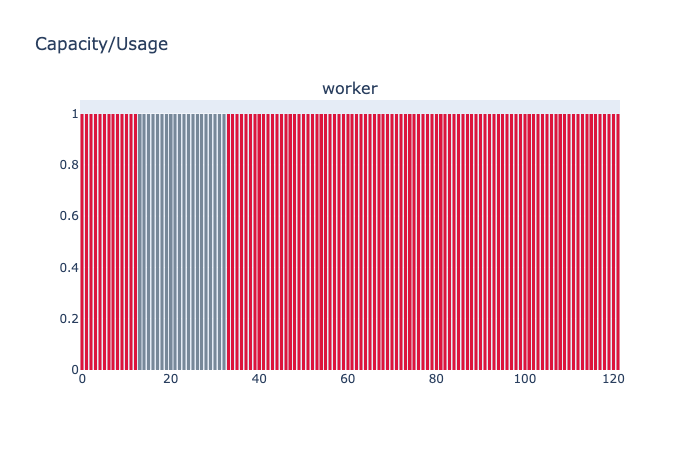

In [ ]:
fig = make_resource_graph(model)
plotly.offline.plot(fig);

## 例題を返す関数

#### 例題１ PERT

あなたは航空機会社のコンサルタントだ．
あなたの仕事は，着陸した航空機をなるべく早く離陸させるためのスケジュールをたてることだ．
航空機は，再び離陸する前に幾つかの作業をこなさなければならない．
まず，乗客と荷物を降ろし，次に機内の掃除をし，最後に新しい乗客を搭乗させ，新しい荷物を積み込む．
当然のことであるが，
乗客を降ろす前に掃除はできず，掃除をした後でないと新しい乗客を入れることはできず，
荷物をすべて降ろし終わった後でないと，新しい荷物は積み込むことができない．
また，この航空機会社では，
乗客用のゲートの都合で，荷物を降ろし終わった後でないと新しい乗客を搭乗させることができないのだ．
作業時間は，乗客降ろし $13$ 分，荷物降ろし $25$ 分，機内清掃 $15$ 分，新しい乗客の搭乗 $27$ 分，
新しい荷物の積み込み $22$ 分とする．
さて，最短で何分で離陸できるだろうか？

これは，**PERT**(Program Evaluation and Review Technique)とよばれる，スケジューリング理論の始祖とも言える古典的なモデルである．
ちなみに，PERTは，第2次世界大戦中における米国海軍のポラリス潜水艦に搭載するミサイルの
設計・開発時間の短縮に貢献したことで有名になり，その後オペレーションズ・リサーチの技法の代表格となった．


In [ ]:
#export
def ex1():
    """
    Example 1
    PERT
    file name: Example1.py
    Copyright Log Opt Co., Ltd.

    Consider a 5-activity problem with precedence constraints between the activities.
    Such a problem is called PERT (Program Evaluation and Review Technique).
    The processing times (durations) of the activities are kept in the dictionary
     duration ={1:13, 2:25, 3:15, 4:27, 5:22 }.
    Precedence constraints are given by:
     Activity 1 -> Activity 3; Activity 2 -> Activity 4;
     Activity 3 -> Activity 4; and Activity 3 -> Activity 5.
    The objective is to find the maximum completion time (makespan) for all 5 activities.
    """

    m1 = Model()
    duration = {1: 13, 2: 25, 3: 15, 4: 27, 5: 22}
    act = {}
    mode = {}
    for i in duration:
        act[i] = m1.addActivity("Act[{0}]".format(i))
        mode[i] = Mode("Mode[{0}]".format(i), duration[i])
        act[i].addModes(mode[i])

    # temporal (precedense) constraints
    m1.addTemporal(act[1], act[3])
    m1.addTemporal(act[2], act[4])
    m1.addTemporal(act[2], act[5])
    m1.addTemporal(act[3], act[4])

    m1.Params.TimeLimit = 1
    m1.Params.Makespan = True
    return m1

In [ ]:
model = ex1()
model.optimize()
#model.write(folder + "chart1.txt")
fig = make_gannt(model, start = "2020/01/01", period ="minutes")
#plotly.offline.plot(fig);
print(model)


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    55    55
    Act[1]   ---     0    13
    Act[2]   ---     0    25
    Act[3]   ---    13    28
    Act[4]   ---    28    55
    Act[5]   ---    25    47
Model:
number of activities= 5
number of resources= 0

Activity Information
activity Act[1] 
 mode  duration 13  
activity Act[2] 
 mode  duration 25  
activity Act[3] 
 mode  duration 15  
activity Act[4] 
 mode  duration 27  
activity Act[5] 
 mode  duration 22  

Temporal Constraint Information
temporal Act[1] Act[3]  type CS delay 0 
temporal Act[2] Act[4]  type CS delay 0 
temporal Act[2] Act[5]  type CS delay 0 
temporal Act[3] Act[4]  type CS delay 0 


#### 例題２ 資源制約付きPERT

あなたは航空機会社のコンサルタントだ．
リストラのため作業員の大幅な削減を迫られたあなたは，
例題1と同じ問題を1人の作業員で行うためのスケジュールを作成しなければならなくなった．
作業時間や時間制約は，前節と同じであるとするが，各々の作業は作業員を1人占有する（すなわち，2つの作業を同時にできない）
ものとする．
どのような順序で作業を行えば，最短で離陸できるだろうか？


この問題は資源制約付きプロジェクトスケジューリング問題になるので，$NP$-困難であるが，OptSeqを用いればやはり容易に解くことができる．


In [ ]:
#export
def ex2():
    """
    Example 2
    PERT with resource constraint
    file name: Example2.py
    Copyright Log Opt Co., Ltd.

    Consider a 5-activity problem with precedence constraints between the activities.
    The processing times (durations) of the activities are kept in the dictionary
     duration ={1:13, 2:25, 3:15, 4:27, 5:22 }.
    Precedence constraints are given by:
     Activity 1 -> Activity 3; Activity 2 -> Activity 4;
     Activity 3 -> Activity 4; and Activity 3 -> Activity 5.
    Each activity requires one unit of worker resource whose capacity (maximum amount of availability for each time period) is 1.
    The objective is to find the maximum completion time (makespan) for all 5 activities
    """
    m1=Model()
    duration ={1:13, 2:25, 3:15, 4:27, 5:22 }
    #res=m1.addResource("worker",capacity={(0,"inf"):1})
    res=m1.addResource("worker",capacity=1)

    act={}
    mode={}
    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,requirement=1)
        act[i].addModes(mode[i])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[3])
    m1.addTemporal(act[2],act[4])
    m1.addTemporal(act[2],act[5])
    m1.addTemporal(act[3],act[4])

    ###作業1の開始時刻を計画期間開始時刻の10分後に固定する制約
    #m1.addTemporal('source',act[1],'SS',10)
    #m1.addTemporal(act[1],'source','SS',-10)

    ###作業2は作業1終了5分～10分の間に開始しなければならないことを表す制約
    #m1.addTemporal(act[1],act[2],'CS',5)
    #m1.addTemporal(act[2],act[1],'SC',-10)

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 7
objective value = 102 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 102/102

--- best solution ---
source,---, 0 0
sink,---, 102 102
Act[1],---, 47 47--60 60
Act[2],---, 0 0--25 25
Act[3],---, 60 60--75 75
Act[4],---, 75 75--102 102
Act[5],---, 25 25--47 47
--- tardy activity ---
sink: 102
--- resource residuals ---
worker: [0,102] 0 

--- best activity list ---
source ---
Act[2] ---
Act[5] ---
Act[1] ---
Act[3] ---
Act[4] ---
sink ---

objective value = 102
cpu time = 0.00/1.00(s)
iteration = 0/85277


Solutions:
    source   ---     0     0
      sink   ---   102   102
    Act[1]   ---    47    60
    Act[2]   ---     0    25
    Act[3]   ---    60    75
    Act[4]   ---    75   102
    Act[5]   ---    25  

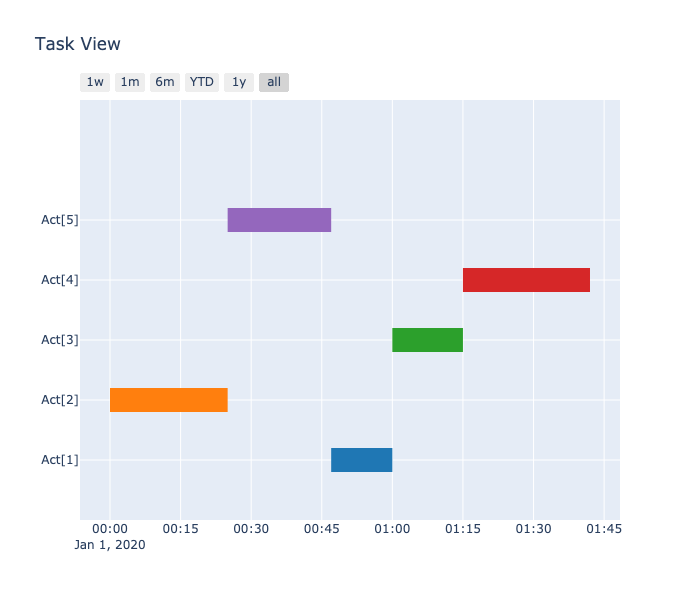

In [ ]:
model = ex2()
model.optimize()
#model.write(folder +"chart2.txt")
fig = make_gannt(model, start = "2020/01/01", period ="minutes")
#plotly.offline.plot(fig);

#### 例題３ 並列ショップスケジューリング

あなたはF1のピットクルーだ．
F1レースにとってピットインの時間は貴重であり，
ピットインしたレーシングカーに適切な作業を迅速に行い，
なるべく早くレースに戻してやることが，あなたの使命である．

- 作業1：  給油準備 (3秒)
- 作業2：  飲料水の取り替え　 (2秒)
- 作業3：  フロントガラス拭き (2秒)
- 作業4：  ジャッキで車を持ち上げ (2秒)
- 作業5：  タイヤ (前輪左側) 交換 (4秒)
- 作業6：  タイヤ (前輪右側) 交換 (4秒)
- 作業7：  タイヤ (後輪左側) 交換 (4秒)
- 作業8：  タイヤ (後輪右側) 交換 (4秒)
- 作業9：  給油 (11秒)
- 作業10：  ジャッキ降ろし (2秒)

各作業には，作業時間のほかに，
この作業が終わらないと次の作業ができないといったような時間制約がある．
作業時間と時間制約は，以下の図のようになっている．

いま，あなたを含めて3人のピットクルーがいて，
これらの作業を手分けして行うものとする．
作業は途中で中断できないものとすると，
なるべく早く最後の作業を完了させるには，
誰がどの作業をどういう順番で行えばよいのだろうか？

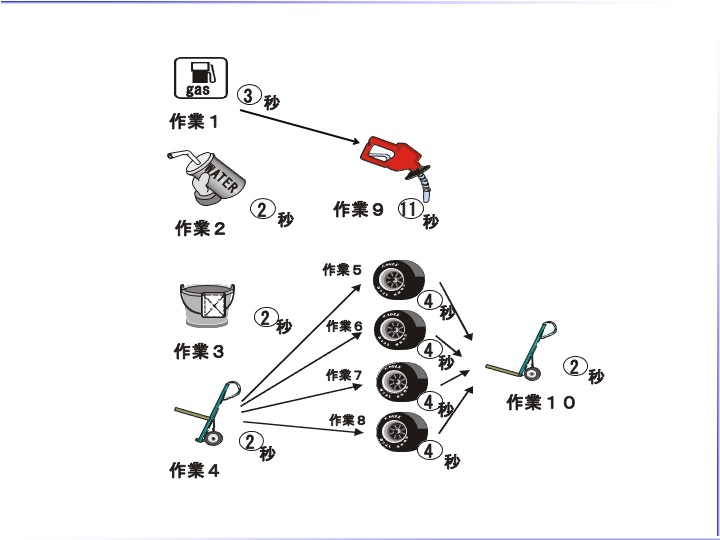

In [ ]:
Image("figure/optseq-ex2.jpg")

In [ ]:
#export
def ex3():
    """
    Example 3
    Parallel Shop Problem
    file name: Example3.py
    Copyright Log Opt Co., Ltd.

    Consider a 10-activity problem in which each activity is processed on three identical parallel machines.
    The processing times (durations) of the activities are kept in the dictionary
     duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }.
    Precedence constraints are given by:
     Activity 1 -> Activity 9;
     Activities 5,6,7,8 are processed after Activity 4 and before Activity 10.
    The objective is to find the maximum completion time (makespan).
    """

    m1=Model()
    duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }
    res=m1.addResource("worker",capacity={(0,"inf"):3})
    act={}
    mode={}
    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,{(0,"inf"):1})
        act[i].addModes(mode[i])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[9])
    for i in range(5,9):
        m1.addTemporal(act[4],act[i])
        m1.addTemporal(act[i],act[10])

    m1.Params.TimeLimit=1
    m1.Params.Makespan=True
    m1.Params.OutputFlag=True
    return m1


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 12
objective value = 14 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 14/14

--- best solution ---
source,---, 0 0
sink,---, 14 14
Act[1],---, 0 0--3 3
Act[2],---, 0 0--2 2
Act[3],---, 0 0--2 2
Act[4],---, 2 2--4 4
Act[5],---, 8 8--12 12
Act[6],---, 4 4--8 8
Act[7],---, 8 8--12 12
Act[8],---, 4 4--8 8
Act[9],---, 3 3--14 14
Act[10],---, 12 12--14 14
--- tardy activity ---
sink: 14
--- resource residuals ---
worker: [0,2] 0 [2,4] 1 [4,12] 0 [12,14] 1 

--- best activity list ---
source ---
Act[1] ---
Act[2] ---
Act[9] ---
Act[3] ---
Act[4] ---
Act[8] ---
Act[6] ---
Act[5] ---
Act[7] ---
Act[10] ---
sink ---

objective value = 14
cpu time = 0.00/1.00(s)
iteration = 0/12109


Solutions:
    source   ---     0     

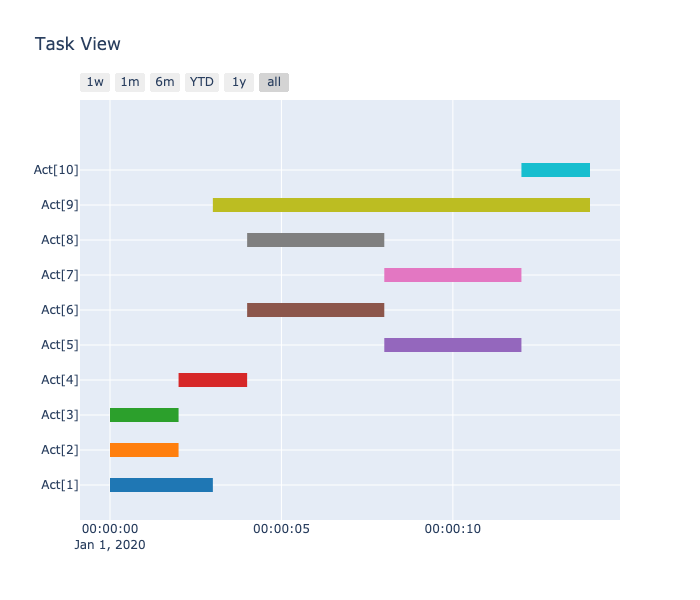

In [ ]:
model = ex3()
model.optimize()
#model.write(folder +"chart3.txt")
#fig = make_gannt(model, start = "2020/01/01", period ="seconds")
#plotly.offline.plot(fig);
#fig2 = make_resource_graph(model)
#plotly.offline.plot(fig2);
Image("figure/ex3.png")

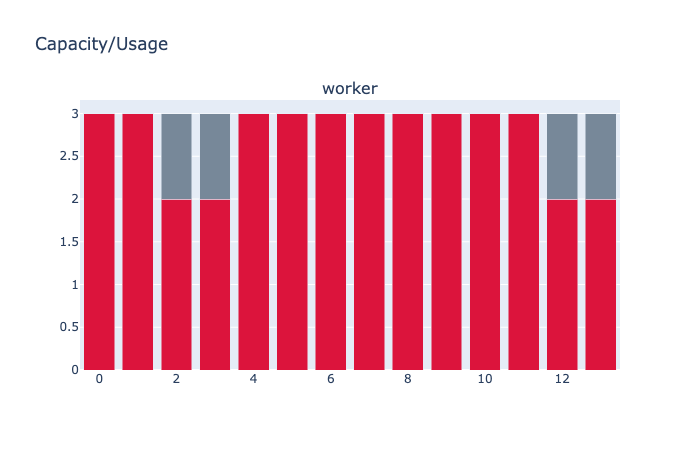

In [ ]:
Image("figure/ex3-2.png")

#### 例題４ モードの利用

上と同じ例題において、作業１が以下の３つのモード（作業方法）で処理できるものとする。

1. 1人の作業員で行い３秒かかる。
2. 2人の作業員で行い２秒かかる。
3. 3人の作業員で行い１秒かかる。

さて、どのモードを採用し、どのようなスケジュールで作業を行えば、最短で終了するか？

In [ ]:
#export
def ex4():
    """
    Example 4
    Parallel Shop Problem using Modes
    file name: Example4.py
    Copyright Log Opt Co., Ltd.

    Consider a 10-activity problem in which each activity is processed on three identical parallel machines.
    The processing times (durations) of the activities are kept in the dictionary
     duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }.
    Precedence constraints are given by:
     Activity 1 -> Activity 9;
     Activities 5,6,7,8 are processed after Activity 4 and before Activity 10.
    Activity 1 can be processed in one of the following three modes:
     Mode 1 with duration 3 that requires 1 unit of worker resource,
     Mode 2 with duration 2 that requires 2 units of worker resource, and
     Mode 3 with duration 1 that requires 3 units of worker resource.
    The objective is to find the maximum completion time (makespan).
    """

    m1=Model()
    duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }
    res=m1.addResource("worker",capacity=3)
    act={}
    mode={}

    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i))
        if i==1:
            mode[1,1]=Mode("Mode[1_1]",3)
            mode[1,1].addResource(res,1)
            mode[1,2]=Mode("Mode[1_2]",2)
            mode[1,2].addResource(res,2)
            mode[1,3]=Mode("Mode[1_3]",1)
            mode[1,3].addResource(res,3)
            act[i].addModes(mode[1,1],mode[1,2],mode[1,3])
        else:
            mode[i]=Mode("Mode[{0}]".format(i),duration[i])
            mode[i].addResource(res,1)
            act[i].addModes(mode[i])
    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[9])
    for i in range(5,9):
        m1.addTemporal(act[4],act[i])
        m1.addTemporal(act[i],act[10])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1

In [ ]:
model = ex4()
model.optimize()
#model.write(folder +"chart4.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 12
objective value = 14 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 14/14
objective value = 13 (cpu time = 0.00(s), iteration = 6)

--- best solution ---
source,---, 0 0
sink,---, 13 13
Act[1],Mode[1_3], 0 0--1 1
Act[2],---, 11 11--13 13
Act[3],---, 1 1--3 3
Act[4],---, 1 1--3 3
Act[5],---, 3 3--7 7
Act[6],---, 7 7--11 11
Act[7],---, 7 7--11 11
Act[8],---, 3 3--7 7
Act[9],---, 1 1--12 12
Act[10],---, 11 11--13 13
--- tardy activity ---
sink: 13
--- resource residuals ---
worker: [0,12] 0 [12,15] 2 

--- best activity list ---
source ---
Act[1] Mode[1_3]
Act[3] ---
Act[4] ---
Act[8] ---
Act[5] ---
Act[9] ---
Act[6] ---
Act[7] ---
Act[2] ---
Act[10] ---
sink ---

objective value = 13
cpu time = 0.00/1.00(s)
ite

#### 例題５ 資源制約付きスケジューリング

あなたは1階建てのお家を造ろうとしている大工さんだ．
あなたの仕事は，なるべく早くお家を完成させることだ．
お家を造るためには，幾つかの作業をこなさなければならない．
まず，土台を造り，1階の壁を組み立て，屋根を取り付け，さらに１階の内装をしなければならない．
ただし，土台を造る終える前に1階の建設は開始できず，内装工事も開始できない．
また，1階の壁を作り終える前に屋根の取り付けは開始できない．

各作業とそれを行うのに必要な時間（単位は日）は，以下のようになっている．

- 土台：  2人の作業員で1日
- １階の壁： 最初の1日目は2人，その後の2日間は1人で，合計3日
- 内装： 1人の作業員で2日
- 屋根： 最初の1日は1人，次の１日は2人の作業員が必要で，合計2日

いま，作業をする人は，あなたをあわせて2人いるが，相棒の1人は作業開始3日目に休暇をとっている．
さて，最短で何日でお家を造ることができるだろうか？

In [ ]:
#export
def ex5():
    """
    Example 5
    Resource Constrained Scheduling
    file name: Example5.py
    Copyright Log Opt Co., Ltd.

    Consider a 4-activity problem with a resource whose capacity is 2 units on day 1, 2, 4, 5, 6, and 1 unit on day 3.
    The processing times (durations) of the activities are kept in the dictionary
     duration ={1:1,2:3,3:2,4:2}.
    Precedence constraints are give by:
     Activity 1 -> Activity 2;
     Activity 1 -> Activity 3;
     Activity 2 -> Activity 4.
    Activity 1 requires 2 units of resource the first day.
    Activity 2 requires 2 units of resource the first day and 1 unit on other days.
    Activity 3 requires 1 unit of resource all the days.
    Activity 4 requires 1 unit of the resource the first day and 2 units on the second day.
    The objective is to find the maximum completion time (makespan).
    """

    m1=Model()
    duration ={1:1,2:3,3:2,4:2}
    req={}
    req[1]={(0,1):2 }
    req[2]={(0,1):2 ,(1,3):1}
    req[3]={(0,2):1 }
    req[4]={(0,1):1,(1,2):2 }

    res=m1.addResource("worker")
    res.addCapacity(0,2,2)
    res.addCapacity(2,3,1)
    res.addCapacity(3,"inf",2)

    act={}
    mode={}

    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,requirement=req[i])
        act[i].addModes(mode[i])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[2])
    m1.addTemporal(act[1],act[3])
    m1.addTemporal(act[2],act[4])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1

In [ ]:
model = ex5()
model.optimize()
#model.write(folder +"chart5.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 6
objective value = 6 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 6/6

--- best solution ---
source,---, 0 0
sink,---, 6 6
Act[1],---, 0 0--1 1
Act[2],---, 1 1--4 4
Act[3],---, 3 3--5 5
Act[4],---, 4 4--6 6
--- tardy activity ---
sink: 6
--- resource residuals ---
worker: [0,6] 0 

--- best activity list ---
source ---
Act[1] ---
Act[2] ---
Act[4] ---
Act[3] ---
sink ---

objective value = 6
cpu time = 0.00/1.00(s)
iteration = 0/61788


Solutions:
    source   ---     0     0
      sink   ---     6     6
    Act[1]   ---     0     1
    Act[2]   ---     1     4
    Act[3]   ---     3     5
    Act[4]   ---     4     6


#### 例題６ 納期遅れ最小化スケジューリング

あなたは売れっ子連載作家だ．あなたは，A, B, C, D の4社から原稿を依頼されており，
それぞれ，どんなに急いで書いても $1$ 日，$2$ 日，$3$ 日，$4$ 日かかるものと思われる．
各社に約束した納期は，それぞれ $5$ 日後，$9$ 日後，$6$ 日後，$4$ 日後であり，
納期から $1$ 日遅れるごとに $1$ 万円の遅延ペナルティを払わなければならない．

どのような順番で原稿を書けば，支払うペナルティ料の合計を最小にできるだろうか？

In [ ]:
#export
def ex6():
    """
    Example 6
    Minimizing the Tardiness
    file name: Example6.py
    Copyright Log Opt Co., Ltd.

    Consider a 4-activity problem with one machine resource.
    The due dates and processing times (durations) of the activities are kept in the dictionaries
     due={1:5,2:9,3:6,4:4} and
     duration={1:1, 2:2, 3:3, 4:4 }, respectively.
    We have to pay tardiness penalty by the amount the completion time of the activity exceeds its due date.
    The objective is to find the schedule that minimizes total tardiness penalty cost.
    """

    m1=Model()
    due={1:5,2:9,3:6,4:4}
    duration={1:1, 2:2, 3:3, 4:4 }

    res=m1.addResource("writer")
    res.addCapacity(0,"inf",1)

    act={}
    mode={}

    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i),duedate=due[i])
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,{(0,"inf"):1})
        act[i].addModes(mode[i])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=False
    return m1

In [ ]:
model = ex6()
#print(model)
model.optimize()
#model.write(folder +"chart6.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 6
objective value = 5 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 5/5
objective value = 3 (cpu time = 0.00(s), iteration = 1)

--- best solution ---
source,---, 0 0
sink,---, 10 10
Act[1],---, 4 4--5 5
Act[2],---, 8 8--10 10
Act[3],---, 5 5--8 8
Act[4],---, 0 0--4 4
--- tardy activity ---
Act[2]: 1
Act[3]: 2
--- resource residuals ---
writer: [0,10] 0 

--- best activity list ---
source ---
Act[4] ---
Act[1] ---
Act[3] ---
Act[2] ---
sink ---

objective value = 3
cpu time = 0.00/1.00(s)
iteration = 1/73700


Solutions:
    source   ---     0     0
      sink   ---    10    10
    Act[1]   ---     4     5
    Act[2]   ---     8    10
    Act[3]   ---     5     8
    Act[4]   ---     0     4


#### 例題７ クリティカルパス法

あなたは，航空機会社のコンサルタントだ．
今度は，作業時間の短縮を要求されている．
（ただし，資源制約（人の制限）はないものとする．）
いま，航空機の離陸の前にする作業の時間が，費用をかけることによって短縮でき，
各作業の標準時間，新設備導入によって短縮したときの時間，ならびにそのときに必要な費用は，
以下のように推定されているものとする．

- 作業1： 乗客降ろし $13$ 分．$10$ 分に短縮可能で，$1$ 万円必要．
- 作業2： 荷物降ろし $25$ 分．$20$ 分に短縮可能で，$1$ 万円必要．
- 作業3： 機内清掃 $15$ 分．$10$ 分に短縮可能で， $1$ 万円必要．
- 作業4： 新しい乗客の搭乗 $27$ 分．$25$ 分に短縮可能で， $1$ 万円必要．
- 作業5： 新しい荷物積み込み $22$ 分．$20$ 分に短縮可能で， $1$ 万円必要．

さて，いくら費用をかけると，どのくらい離陸時刻を短縮することができるだろうか？


これは，クリティカルパス法(Critical Path Method; CPM)とよばれる古典的な問題である．
CPMは，作業時間を費用（お金）をかけることによって短縮できるという仮定のもとで，
費用と作業完了時刻のトレードオフ曲線を求めることを目的としたPERTの変形で，資源制約が
ないときには効率的な解法が古くから知られているが，資源制約がつくと困難な問題になる．
ここでは，この問題が「モード」と「再生不能資源」を用いて，OptSeqでモデル化できることを示す．

作業は通常の作業時間と短縮時の作業時間をもつが，これは作業に付随するモードで表現することができる．
問題となるのは，作業時間を短縮したときには，費用がかかるという部分である．
費用は資源の一種と考えられるが，いままで考えていた資源とは異なる種類の資源である．

いままで考えていた資源は，機械や人のように，作業時間中は使用されるが，
作業が終了すると，再び別の作業で使うことができるようになる．
このような，作業完了後に再び使用可能になる資源を，再生可能資源(renewable resource)とよぶ．

一方，費用（お金）や原材料のように，一度使うとなくなってしまう資源を，
再生不能資源(nonrenewable resource)とよぶ．

CPMの例題に対して，再生不能資源（お金）の上限を色々変えて最短時間を求める．
まず，各々の作業に対して，通常の作業時間をもつ場合と，短縮された作業時間をもつ場合の
2つのモードを追加し，さらに短縮モードを用いた場合には，再生不能資源を $1$単位使用するという条件を付加する．


In [ ]:
#export
def ex7():
    """
    Example 7
    CPM(critical path method) -- nonrenewable resource
    file name: Example7.py
    Copyright Log Opt Co., Ltd.

    Consider the same scenario as in Example 1.
    Here, activities have a standard mode and an express mode whose durations are
    durationA = {1:13, 2:25, 3:15, 4:27, 5:22 } and
    durationB = {1:10, 2:20, 3:10, 4:25, 5:20 }, respectively.
    Express modes require additional costs; they can be processed at most 4.
    Find the makespan under the restriction.

    """

    m1=Model()
    Jobs=[1,2,3,4,5]
    durationA = {1:13, 2:25, 3:15, 4:27, 5:22 }
    durationB = {1:10, 2:20, 3:10, 4:25, 5:20 }

    act={}
    mode={}
    for i in Jobs:
        mode[i,1]=Mode("Mode[{0}][1]".format(i),durationA[i])
        mode[i,2]=Mode("Mode[{0}][2]".format(i),durationB[i])
        act[i]=m1.addActivity("Act[{0}] ".format(i))
        act[i].addModes(mode[i,1],mode[i,2])


    res=m1.addResource("money",rhs=5,direction="<=")

    for i in Jobs:
        res.addTerms(1,act[i],mode[i,2])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[3])
    m1.addTemporal(act[2],act[4])
    m1.addTemporal(act[2],act[5])
    m1.addTemporal(act[3],act[4])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1

In [ ]:
model = ex7()
model.optimize()
#model.write(folder +"chart7.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 7
objective value = 45 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 45/45

--- best solution ---
source,---, 0 0
sink,---, 45 45
Act[1]_,Mode[1][2], 0 0--10 10
Act[2]_,Mode[2][2], 0 0--20 20
Act[3]_,Mode[3][2], 10 10--20 20
Act[4]_,Mode[4][2], 20 20--45 45
Act[5]_,Mode[5][2], 20 20--40 40
--- tardy activity ---
sink: 45
--- resource residuals ---

--- best activity list ---
source ---
Act[2]_ Mode[2][2]
Act[5]_ Mode[5][2]
Act[1]_ Mode[1][2]
Act[3]_ Mode[3][2]
Act[4]_ Mode[4][2]
sink ---

objective value = 45
cpu time = 0.00/1.00(s)
iteration = 0/209778


Solutions:
    source   ---     0     0
      sink   ---    45    45
   Act[1]_ Mode[1][2]     0    10
   Act[2]_ Mode[2][2]     0    20
   Act[3]_ Mode[3][2]

#### 例題８ 時間制約

OptSeqでは，通常の先行制約の他に，様々な時間に関する制約が準備されている．
時間制約を用いることによって，実際問題で発生する様々な付加条件をモデル化することができる．

時間制約の適用例として，最初に示したPERTの例題において，
作業3と作業5の開始時刻が一致しなければならないという制約を考えてみる．

開始時刻を一致させるためには，制約タイプは SS（Start-Startの関係）とし，時間ずれは $0$ と設定する．
また，制約は「作業3の開始時刻 $\leq$ 作業5の開始時刻」と「作業5の開始時刻 $\leq$ 作業3の開始時刻」の2本を追加する．

また，作業の開始時間の固定も，この時間制約を用いると簡単にできる．
OptSeqでは，すべての作業に先行するダミーの作業'source'が準備されている．
この作業は必ず時刻 $0$ に処理されるので，
開始時刻に相当する時間ずれをもつ時間制約を2本追加することによって，開始時刻を固定することができる．

たとえば，作業5（名前はact[5]）の開始時刻を $50$分に固定したい場合には，
```python
model.addTemporal('source', act[5],'SS',delay=50)
model.addTemporal(act[5], 'source','SS',delay=-50)
```
と時間制約を追加する．

In [ ]:
#export
def ex8():
    """
    Example 8
    Temporal Constraints
    file name: Example8.py
    Copyright Log Opt Co., Ltd.

    Consider the same scenario as in Example 1.
    Here, we add an additional temporal constraint; Activity 3 and Activity 5 must be start simultaneously.
    Find the makespan under this new condition.

    """

    m1=Model()
    durationA = {1:13, 2:25, 3:15, 4:27, 5:22 }

    act={}
    mode={}

    for i in durationA:
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i),durationA[i])
        act[i].addModes(mode[i])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[3])
    m1.addTemporal(act[2],act[4])
    m1.addTemporal(act[2],act[5])
    m1.addTemporal(act[3],act[4])

    #act[3] and act[5] start at the same time
    m1.addTemporal(act[3],act[5],"SS",0)
    m1.addTemporal(act[5],act[3],"SS",0)

    # act[5] begins at time 50
    m1.addTemporal("source",act[5],"SS",delay=50)
    m1.addTemporal(act[5],"source","SS",delay=-50)

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1

In [ ]:
model = ex8()
model.optimize()
#model.write(folder +"chart8.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 6
objective value = 92 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 92/92

--- best solution ---
source,---, 0 0
sink,---, 92 92
Act[1],---, 0 0--13 13
Act[2],---, 0 0--25 25
Act[3],---, 50 50--65 65
Act[4],---, 65 65--92 92
Act[5],---, 50 50--72 72
--- tardy activity ---
sink: 92
--- resource residuals ---

--- best activity list ---
source ---
Act[1] ---
Act[2] ---
Act[5] ---
Act[3] ---
Act[4] ---
sink ---

objective value = 92
cpu time = 0.00/1.00(s)
iteration = 0/462885


Solutions:
    source   ---     0     0
      sink   ---    92    92
    Act[1]   ---     0    13
    Act[2]   ---     0    25
    Act[3]   ---    50    65
    Act[4]   ---    65    92
    Act[5]   ---    50    72


#### 例題９ 作業の途中中断 

多くの実際問題では，緊急の作業などが入ってくると，いま行っている作業を途中で中断して，
別の（緊急で行わなければならない）作業を行った後に，再び中断していた作業を途中から
行うことがある．このように，途中で作業を中断しても，再び（一から作業をやり直すのではなく）
途中から作業を続行することを「作業の途中中断」とよぶ．

OptSeqでは，これを作業を分割して処理することによって表現する．
たとえば，作業時間が$3$時間の作業があったとする．
時間の基本単位を$1$時間としたとき，この作業は，$1$ 時間の作業時間をもつ $3$ つの小作業に分割して処理される．

しかし，実際問題では，中断可能なタイミングが限られている場合もある．
たとえば，料理をするときに，材料を切ったり，混ぜたりするときには，途中で中断することも可能だが，
いったんオーブンレンジに入れたら，途中でとめたりすることはできない．

OptSeqでは，作業（モード）の時間の区間に対して，最大中断可能時間を入力することによって，様々な作業の**中断**(break)を表現する．

例として，納期遅れ最小化問題において，すべての作業がいつでも最大1日だけ中断できる場合を考える．


作業の途中中断は，
```python
addBreak(区間の開始時刻,区間の終了時刻,最大中断時間)
```
を用いて追加する．

また，段取りを伴う生産現場においては，中断の途中で他の作業を行うことが禁止されている場合がある．
これは，休日の間に異なる作業を行うと，
再び段取りなどの処理を行う必要があるため，作業を一からやり直さなければならないからである．
これは，作業の中断中でも資源を使い続けていると表現することによって回避することができる．

中断中に資源を使用する場合も，通常の資源を追加するのと同様に**addResource**メソッドを用いて追加する．
この場合，引数として
```python
資源,{(区間):資源使用量},'break'
```
を入力する．

例題の資源を表す「作家」が4日目と7日目と11日目に休暇をとるとしたときの中断を考慮したスケジュールは、以下の関数で定義される。


In [ ]:
#export
def ex9():
    """
    Example 9
    Breakable Activity
    file name: Example9.py
    Copyright Log Opt Co., Ltd.

    Consider the same scenario as in Example 6.
    Here, Activities can interrupt their processing and re-start after one unit of break time.
    Find the optimal schedule (minimum tardiness solution) under this new condition.
    """

    m1=Model()

    due={1:5,2:9,3:6,4:4}
    duration={1:1, 2:2, 3:3, 4:4 }

    res=m1.addResource("writer")
    res.addCapacity(0,3,1)
    res.addCapacity(4,6,1)
    res.addCapacity(7,10,1)
    res.addCapacity(11,"inf",1)

    act={}
    mode={}

    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i),duedate=due[i])
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,{(0,"inf"):1})
        mode[i].addBreak(0,"inf",1)
        #mode[i].addBreak(0,1,1) #開始後１日までしか中断を入れられない場合にはここを生かす．
        mode[i].addResource(res,{(0,"inf"):1},"break") #break中も資源を使う場合にはここを生かす。
        act[i].addModes(mode[i])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=False
    return m1

In [ ]:
model = ex9()
model.optimize()
#model.write(folder +"chart9.txt")
#fig = make_gannt(model, start = "2020/01/01", period ="days")
#plotly.offline.plot(fig);
#fig2 = make_resource_graph(model)
#plotly.offline.plot(fig2);
#Image("../figure/ex9.png")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 6
objective value = 15 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 15/15
objective value = 11 (cpu time = 0.00(s), iteration = 1)

--- best solution ---
source,---, 0 0
sink,---, 15 15
Act[1],---, 4 4--5 5
Act[2],---, 7 7--9 9
Act[3],---, 0 0--3 3
Act[4],---, 11 11--15 15
--- tardy activity ---
Act[4]: 11
--- resource residuals ---
writer: [0,5] 0 [5,6] 1 [6,9] 0 [9,10] 1 [10,15] 0 

--- best activity list ---
source ---
Act[4] ---
Act[3] ---
Act[1] ---
Act[2] ---
sink ---

objective value = 11
cpu time = 0.00/1.00(s)
iteration = 2/48670


Solutions:
    source   ---     0     0
      sink   ---    15    15
    Act[1]   ---     4     5
    Act[2]   ---     7     9
    Act[3]   ---     0     3
    Act[4]   ---

#### 例題10 作業の並列実行

並列ショップスケジューリング問題の拡張では，
複数の機械（作業員）によって作業時間が短縮されることを，複数のモードを用いることによって表現していた．
ここでは，複数資源による作業の並列処理を，より簡単に表現するための方法を紹介する．

作業の途中中断と同じように，作業を，単位時間の作業時間をもつ小作業に分解して考える．
いま，資源使用量の上限が $1$ より大きいとき，分解された小作業は，並列して処理できるものとする．
ただし，無制限に並列処理ができない場合も多々あるので，OptSeqでは，最大並列数とよばれるパラメータを用いて表現する．

並列処理は，作業モードに対する**addParallel**メソッドを用いて定義される．
書式は，
```python
addParallel(開始小作業番号,終了小作業番号,最大並列数)
```
である．

たとえば，
```python
mode.addParallel(1,1,3)
mode.addParallel(2,3,2)
```
は, 最初の小作業は最大3個，2番目, 3番目の小作業は最大2個の小作業を並列処理可能であることを意味する.

並列ショップスケジューリング問題において，給油作業（作業時間3秒）を，最初の（1番目の）小作業を最大3個並列可能とした場合を考える。

並列実行中に資源を使用する量は，標準（省略するか引数がNone）だと，各資源の資源使用量の総和になる． 総和でなく，並列実行中の資源の「最大量」を指定したい場合には，以下のように**addResource**メソッドの引数に 'max' を追加する．
```python
資源,{(区間):資源使用量},'max'
```

総和と最大値を同時に設定するとエラーになる．


In [ ]:
#export
def ex10():
    """
    Example 10
    Parallel Execution
    file name: Example10.py
    Copyright Log Opt Co., Ltd.

    Consider the same scenario as in Example 3.
    Here, Activity 1 can be processed in parallel up to 3 units.
    Find the optimal schedule under this new condition.

    """

    m1=Model()
    duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }

    res=m1.addResource("worker")
    res.addCapacity(0,"inf",3)

    act={}
    mode={}

    for i in duration:
        act[i]=m1.addActivity("Act[{0}]".format(i))

        if i==1:
            mode[i]=Mode("Mode[{0}]".format(i),duration[i])
            mode[i].addParallel(1,1,3)
            #mode[i].addResource(res,1)       #並列実行中の資源量が各作業の使用量の総和のときはこちらを生かす
            mode[i].addResource(res,1,'max') #並列実行中で使用する資源量が最大1のときはこちらを生かす
        else:
            mode[i]=Mode("Mode[{0}]".format(i),duration[i])
            mode[i].addResource(res,1)
        act[i].addModes(mode[i])

    #temporal (precedense) constraints
    m1.addTemporal(act[1],act[9])
    for i in range(5,9):
        m1.addTemporal(act[4],act[i])
        m1.addTemporal(act[i],act[10])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=True
    return m1

In [ ]:
model = ex10()
model.optimize()
#model.write(folder +"chart10.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 12
objective value = 14 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 14/14
objective value = 13 (cpu time = 0.00(s), iteration = 5)
objective value = 12 (cpu time = 0.01(s), iteration = 70)

--- best solution ---
source,---, 0 0
sink,---, 12 12
Act[1],---, 0 0--1[3] 1
Act[2],---, 10 10--12 12
Act[3],---, 0 0--2 2
Act[4],---, 0 0--2 2
Act[5],---, 2 2--6 6
Act[6],---, 6 6--10 10
Act[7],---, 6 6--10 10
Act[8],---, 2 2--6 6
Act[9],---, 1 1--12 12
Act[10],---, 10 10--12 12
--- tardy activity ---
sink: 12
--- resource residuals ---
worker: [0,12] 0 

--- best activity list ---
source ---
Act[4] ---
Act[8] ---
Act[1] ---
Act[9] ---
Act[3] ---
Act[5] ---
Act[6] ---
Act[7] ---
Act[2] ---
Act[10] ---
sink ---

objective

#### 例題11 実務的な機械スケジューリング問題

例として，4作業3機械のスケジューリング問題を考える．
各作業はそれぞれ 3つの子作業（これを以下では作業とよぶ）$1$, $2$, $3$ から成り, 
この順序で処理しなくてはならない．
各作業を処理する機械, および処理日数は，以下の表の通りである．

 
|       |小作業1 | 小作業2  | 小作業3 |
| :---  | :---: |  :---:  | :---:  |
| 作業1  | 機械1: 7日 |  機械2: 10日 | 機械3: 4日 | 
| 作業2  | 機械3: 9日|  機械1: 5日 | 機械2 : 11日 | 
| 作業3 | 機械1 : 3日 | 機械3: 9日  |機械2 : 12日 | 
| 作業4 |  機械2 : 6日 |  機械3: 13日 |  機械1 :  9日| 
 

このように，作業によって作業を行う機械の順番が異なる問題は，**ジョブショップ**(job shop)とよばれ，
スケジューリングモデルの中でも難しい問題と考えられている．

目的は最大完了時刻最小化とする．
ここでは，さらに以下のような複雑な条件がついているものと仮定する．

1. 各作業の初めの 2日間は作業員資源を必要とする操作がある．
       この操作は平日のみ, かつ 1日あたり高々2個しか行うことができない．
2. 各作業は，1日経過した後だけ，中断が可能．
3. 機械1での作業は，最初の1日は2個まで並列処理が可能．
4. 機械2に限り, 特急処理が可能．
       特急処理を行うと処理日数は4日で済むが,
       全体で1度しか行うことはできない．
5. 機械1において, 作業1を処理した後は作業2を処理しなくてはならない.

この問題は，機械および作業員資源を再生可能資源とした12作業の
スケジューリングモデルとしてOptSeqで記述できる．

In [ ]:
#export
def ex11():
    """
    A simple test problem for the Resource Constrained Scheduling Solver OptSeq
    file name: Example11.py
    Copyright Log Opt Co., Ltd.

    Consider a small job shop problem consisting of 4 activities and 3 machines.
    Each activity consists of three sub-jobs (operations).
    Operation must be processed in the order of 1,2 and 3 on thecorresponding machines.
    The machines to be processed and the processing time (days) are kept by the dictionary
    JobInfo={   (1,1):(1,7), (1,2):(2,10), (1,3):(3,4),
                (2,1):(3,9), (2,2):(1,5), (2,3):(2,11),
                (3,1):(1,3), (3,2):(3,9), (3,3):(2,12),
                (4,1):(2,6), (4,2):(3,13),(4,3):(1,9)
                }
    that maps a tuple of activity ID and operation ID to a tuple of machine IDand processing time.
    The objective is to minimize the latest completion time of activities (makespan).
    We add the following practical conditions:
    1. Each operation requires the worker resource for the first 2 days.
    The worker resource is available on weekdays only and its capacity(maximum number of operations to be executed in a day) is 2.
    2. Each operation may have a break after 1 day.
    3. Operations on machine 1 can be processed in parallel.
    4. Operations on machine 2 can be processed in an express mode whose processing time is 4 days.
    The express mode is restricted to be at most once in a whole.
    5. On machine 1, operation 2 must be executed just after operation 1.
    """

    m1 = Model()
    # resource declaration
    machine = {}  # define three machines
    for j in range(1, 4):
        machine[j] = m1.addResource(
            "machine[{0}]".format(j), capacity={(0, "inf"): 1})

    # CAP={} #capacity of human resources; two workers are available on weekdays
    # for t in range(9):
    #    CAP[(t*7,t*7+5)]=2
    # manpower=m1.addResource("manpower",capacity=CAP)
    # we may write ...
    manpower = m1.addResource("manpower")
    for t in range(9):
        manpower.addCapacity(t*7, t*7+5, 2)

    # budget constraint
    budget = m1.addResource("budget_constraint", rhs=1)

    # activity declaration (4 activities are processed on three machines)
    # JobInfo containes the info. of operations (activity,1..3):-> machine ID and proc. time
    JobInfo = {(1, 1): (1, 7), (1, 2): (2, 10), (1, 3): (3, 4),
               (2, 1): (3, 9), (2, 2): (1, 5), (2, 3): (2, 11),
               (3, 1): (1, 3), (3, 2): (3, 9), (3, 3): (2, 12),
               (4, 1): (2, 6), (4, 2): (3, 13), (4, 3): (1, 9)
               }
    act = {}
    express = Mode("Express", duration=4)
    express.addResource(machine[2], {(0, "inf"): 1}, "max")
    express.addResource(manpower, {(0, 2): 1})
    express.addBreak(1, 1)
    # express.addParallel(1,1,2)

    mode = {}
    for (i, j) in JobInfo:  # for each job and machine
        act[i, j] = m1.addActivity("Act[{0}][{1}]".format(i, j))
        mode[i, j] = Mode("Mode[{0}][{1}]".format(
            i, j), duration=JobInfo[i, j][1])
        mode[i, j].addResource(machine[JobInfo[i, j][0]], {
                               (0, "inf"): 1}, "max")
        mode[i, j].addResource(manpower, {(0, 2): 1})
        mode[i, j].addBreak(1, 1)
        if JobInfo[i, j][0] == 1:
            mode[i, j].addParallel(1, 1, 2)

        if JobInfo[i, j][0] == 2:
            # activities processed on machine 2 have two modes, Express and Normal.
            act[i, j].addModes(mode[i, j], express)
            # Express mode needs one budget
            budget.addTerms(1, act[i, j], express)
        else:
            act[i, j].addModes(mode[i, j])  # single mode activity
        # print act[i,j]
    # temporal (precedense) constraints
    for i in range(1, 5):
        for j in range(1, 3):
            m1.addTemporal(act[i, j], act[i, j+1])

    # Define that Act[2][2] must be processed just after Act[1][1] on machine 1
    # introduce dummy with duration 0 and can break at time 0
    # it requires machine 1 during the break,
    #  completion of Act[1][1]=start of dummy and completaion of dummy=start of Act[2][2]
    d_act = m1.addActivity("dummy_activity")
    d_mode = Mode("dummy_mode")
    d_mode.addBreak(0, 0)
    d_mode.addResource(machine[1], {(0, 0): 1}, "break")
    d_act.addModes(d_mode)
    m1.addTemporal(act[1, 1], d_act, tempType="CS")
    m1.addTemporal(d_act, act[1, 1], tempType="SC")
    m1.addTemporal(d_act, act[2, 2], tempType="CS")
    m1.addTemporal(act[2, 2], d_act, tempType="SC")

    m1.Params.TimeLimit = 1
    m1.Params.OutputFlag = True
    m1.Params.Makespan = True
    return m1


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 13
objective value = 50 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 50/50
objective value = 47 (cpu time = 0.00(s), iteration = 1)
objective value = 45 (cpu time = 0.00(s), iteration = 2)
objective value = 39 (cpu time = 0.00(s), iteration = 3)
objective value = 38 (cpu time = 0.00(s), iteration = 7)

--- best solution ---
source,---, 0 0
sink,---, 38 38
Act[1][1],---, 2 2--3[2] 3--8 8
Act[1][2],Mode[1][2], 8 8--9 10--19 19
Act[1][3],---, 32 32--33 35--38 38
Act[2][1],---, 0 0--9 9
Act[2][2],---, 9 9--10[2] 10--13 13
Act[2][3],Mode[2][3], 21 21--32 32
Act[3][1],---, 14 14--15[2] 15--16 16
Act[3][2],---, 23 23--32 32
Act[3][3],Express, 32 32--33 35--38 38
Act[4][1],Mode[4][1], 0 0--6 6
Act[4][2],---, 10 10--23

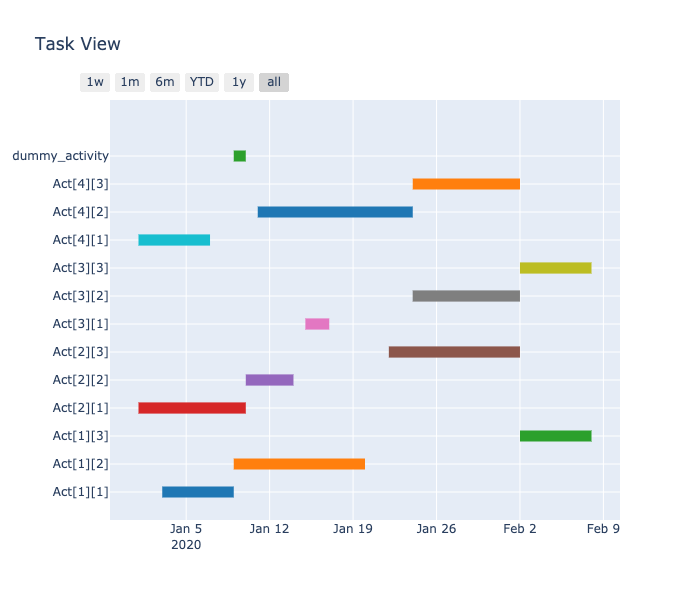

In [ ]:
model = ex11()
model.optimize()
#fig = make_gannt(model, start = "2020/01/01", period ="days")
#plotly.offline.plot(fig);
#fig2 = make_resource_graph(model)
#plotly.offline.plot(fig2);
Image("figure/ex11.png")
#model.write(folder +"chart11.txt")

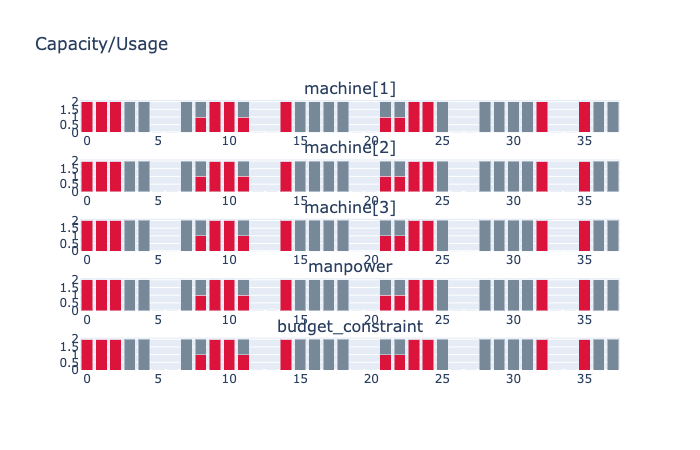

In [ ]:
Image("figure/ex11-2.png")

#### 例題12 状態変数

状態変数とは，時間の経過とともに状態とよばれる非負整数の値が変化する変数である．
作業のモードが，特定の状態でないと開始できないという制約を付加することによって，
通常のスケジューリングモデルでは表現しきれない，様々な付加条件をモデル化することが可能になる．

まず，状態を定義するには，モデルクラスのaddStateメソッドを用いる．
addStateメソッドの引数は，状態の名称を表す文字列であり，返値は状態インスタンスである．
たとえば，無名の状態stateをモデルインスタンスmodelに追加するには，以下のようにする．

```python
state = model.addState()
```

状態は，基本的には1つ前の時刻の値を引き継ぎ，ユーザーの指定によって特定の時刻にその値を変化させることができる変数である．
状態が，ある時間においてある値に変化することを定義するためには， addValueメソッドを用いる．
たとえば，状態インスタンスstateが時刻0に値1になることを定義するには，次のように記述する．

```
state.addValue( time=0, value=1 )
```

状態は，モードで開始された直後に変化させることができる．
そのためには，モードインスタンスのaddStateメソッドを用いて定義する．
addStateメソッドの引数は，状態インスタンスstate， 開始時の状態（fromValue; 非負整数），
開始直後に変化する状態（toValue; 非負変数）である．

```python
モードインスタンス.addState(state, fromValue, toValue)
```

これによって，モード開始時の状態 stateが値 fromValue でなくてはならず，
開始直後（開始時刻が $t$ であれば $t+1$ に）状態が値 toValue に変化することになる．

これによって，処理モードに「ある状態のときしか開始できない」といった制約を加えることが可能になる．

この記述は，状態のとる値を変えて，任意の回数行うことができる．
たとえば，状態変数 state の取り得る値が $1, 2, 3$ の3種類としたとき，
```
mode.addState( state, 1, 2)
mode.addState( state, 2, 3)
mode.addState( state, 3, 1)
```
とすれば，開始時点での状態に関係なく処理は可能で，状態は巡回するように1つずつ変化することになる．

また，これを利用して「あるタイプのモード（以下のmode）は1週間（7日間）に高々3回しか処理できない」ことは，
以下のように表すことができる．

```python
state = model.addState()
state.addValue( time=0,  value=0 ) 
state.addValue( time=7,  value=0 ) 
state.addValue( time=14, value=0 ) 
    ...
mode = Mode('mode')
mode.addState( state, 0, 1)
mode.addState( state, 1, 2)
mode.addState( state, 2, 3)
```

状態は7日ごとに0にリセットされ，モードmodeは状態stateが0,1,2のときだけ開始でき，
状態が3のときには開始できない．したがって7日の間に3回だけ開始できることになる．

上述のような「開始時状態が指定された処理モード」を
与える場合，通常，そのモードを含む作業の定義において，モードを自動選択(autoselect)にしておくことが推奨される.

OptSeqでは，「まず各作業の処理モードをそれぞれ選び，
その後，ある順序にしたがって作業を前づめにスケジュールしていく」
ということの繰り返しを行う．
したがって，「開始時状態が指定された処理モード」が存在すると，
処理モードの選び方によっては，
「スケジュールを生成していくとき，割り付け不可能」
ということが頻繁に起こりえる．
これを防ぐため，「あらかじめ処理モードを指定せず，前づめスケジュールしながら
適切な処理モードを選択する」ことが必要になり，これを実現するのがモードの自動選択なのである．

作業に対してモードを自動選択に設定するには，
作業クラスのコンストラクタの引数 autoselect を用いるか，作業インスタンスの属性 autoselectを用いる．
具体的には，以下の何れの書式でも，自動選択に設定できる．

```python
act1=model.addActivity('Act1', autoselect=True)
act1.autoselect = True
```

**注意**
作業の定義に autoselect を指定した場合には，その作業に制約を逸脱したときの重みを無限大とした
（すなわち絶対制約とした）再生不能資源を定義することはできない．
かならず重みを既定値の無限大 'inf' ではない正数値と設定し直す必要がある．

In [ ]:
#export
def ex12():
    """
    Example 12
    Example with state
    file name: Example12.py
    Copyright Log Opt Co., Ltd.
    """
    m1 = Model()
    n = 9 #number of activities

    state = m1.addState("state")
    state.addValue( time=0,  value=0 )
    state.addValue( time=7,  value=0 )
    state.addValue( time=14, value=0 )

    mode = Mode('mode', 1)
    mode.addState( state, 0, 1)
    mode.addState( state, 1, 2)
    mode.addState( state, 2, 3)

    act ={}
    for i in range(n):
        act[i] = m1.addActivity(f"act{i}", duedate = i, autoselect= True)
        act[i].addModes(mode)

    m1.Params.TimeLimit = 1
    m1.Params.OutputFlag = True
    m1.Params.Makespan = False
    return m1

In [ ]:
model = ex12()
model.optimize()
#model.write(folder +"chart12.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 11
objective value = 45 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 45/45

--- best solution ---
source,---, 0 0
sink,---, 17 17
act0,---, 0 0--1 1
act1,---, 1 1--2 2
act2,---, 2 2--3 3
act3,---, 7 7--8 8
act4,---, 8 8--9 9
act5,---, 9 9--10 10
act6,---, 14 14--15 15
act7,---, 15 15--16 16
act8,---, 16 16--17 17
--- tardy activity ---
act0: 1
act1: 1
act2: 1
act3: 5
act4: 5
act5: 5
act6: 9
act7: 9
act8: 9
--- resource residuals ---

--- best activity list ---
source ---
act0 ---
act1 ---
act2 ---
act3 ---
act4 ---
act5 ---
act6 ---
act7 ---
act8 ---
sink ---

objective value = 45
cpu time = 0.00/1.00(s)
iteration = 0/3807


Solutions:
    source   ---     0     0
      sink   ---    17    17
      act0   --- 

#### 例題13 順序依存の段取り時間

D,E,Fの3つの作業（作業時間は全部30）を１つのライン上で生産する問題を考える。
初期状態startからは、いずれの作業も段取り時間0で作業開始できるが、D,E,Fの間には、以下の表のような順序に依存した作業時間がかかるものとする。

 |    |    D  |   E  |  F   |     
 |:---:|  :---: |  :---:|   :---:|  
 |D    |   -    |   10  |     0  | 
 |E    |  50    |   -   |     10 |  
 |F    |  0     |   10  |     -  | 

これを表現するためには、状態変数を用いる。状態は start, D,E,F であり、それぞれ 0,1,2,3という整数で表すものとする。
各段取りに対して、段取りモード mode_setup[i,j] を準備し、状態がiでないと開始できず、開始すると状態をjに移すものとする。
各作業 act[j] に対して段取り作業 act_setup[j] を準備し、モードmode_setup[i,j]を追加する。
また、段取り作業の終了時刻と、作業act[j]の開始時刻が一致するようにしておく。


In [ ]:
#export
def ex13():
    """
    順序依存の段取り時間の例題
    """

    m1 = Model()

    duration = {"D": 30, "E": 30, "F": 30}
    setup = {("D", "E"): 10, ("E", "D"): 50, ("E", "F"): 10, ("F", "E"): 10,
             ("start", "D"): 0, ("start", "E"): 10, ("start", "F"): 0,
             ("D", "F"): 0, ("F", "D"): 0}
    s = {"D": 1, "E": 2, "F": 3, "start": 0}

    rs = m1.addResource("line1", 1)

    act = {}
    mode = {}
    for i in duration:
        act[i] = m1.addActivity("Act_{0}".format(i))
        mode[i] = Mode("Mode_{0}".format(i), duration[i])
        mode[i].addResource(rs, {(0, "inf"): 1})
        act[i].addModes(mode[i])

    s1 = m1.addState("Setup_State")
    s1.addValue(time=0, value=s["start"])
    # setup mode
    mode_setup = {}
    for (i, j) in setup:
        mode_setup[i, j] = Mode("Mode_setup_{0}_{1}".format(i, j), setup[i, j])
        mode_setup[i, j].addState(s1, s[i], s[j])
        if setup[i, j] != 0:
            mode_setup[i, j].addResource(rs, {(0, setup[i, j]): 1})

        #print (i,j,s[i],s[j],mode_setup[i,j])

    act_setup = {}
    for k in duration:
        act_setup[k] = m1.addActivity("Setup_{0}".format(k), autoselect=True)
        for (i, j) in setup:
            if k == j:
                act_setup[k].addModes(mode_setup[i, j])

    # temporal (precedense) constraints
    for j in act_setup:
        m1.addTemporal(act_setup[j], act[j], "CS")
        m1.addTemporal(act[j], act_setup[j], "SC")

    # print(m1)
    # m1.Params.Initial="Example13initial.txt"
    m1.Params.TimeLimit = 1
    m1.Params.OutputFlag = True
    m1.Params.Makespan = True
    return m1

In [ ]:
model = ex13()
model.optimize()
#model.write(folder +"chart13.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 5
objective value = 100 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 100/100

--- best solution ---
source,---, 0 0
sink,---, 100 100
Act_D,---, 30 30--60 60
Act_E,---, 70 70--100 100
Act_F,---, 0 0--30 30
Setup_D,Mode_setup_F_D, 30 30
Setup_E,Mode_setup_D_E, 60 60--70 70
Setup_F,Mode_setup_start_F, 0 0
--- tardy activity ---
sink: 100
--- resource residuals ---
line1: [0,150] 0 

--- best activity list ---
source ---
Setup_F Mode_setup_start_F
Act_F ---
Setup_D Mode_setup_F_D
Act_D ---
Setup_E Mode_setup_D_E
Act_E ---
sink ---

objective value = 100
cpu time = 0.00/1.00(s)
iteration = 0/67039


Solutions:
    source   ---     0     0
      sink   ---   100   100
     Act_D   ---    30    60
     Act_E   ---  

#### 例題14 貯蔵資源の表現方法

２つの作業（１３時間と２５時間の作業時間）を考える。作業１の開始後、３時間後に作業２が開始できる。
作業１で製造された半製品は２つのタンク（Tank１,２）のいずれかに保管する必要がある。
タンク１は常に使用可能であるが、タンク２は１０時間後にメンテナンスが予定されているため、使うことができない。

半製品はダミーの作業(dummy)で表現され、タンク1,2の使用を表す2つのモード (modeDum1,2)をもつ。
これらのモードは作業時間は0だが、開始後に休憩可能 (breakable) とし、開始は作業１の開始時、終了は作業２の終了時と設定する。

半製品は長時間保管すると劣化するので、休憩は最大10時間と設定すると、実行不能になり、最大３０時間と設定すると実行可能になる。

In [ ]:
#export
def ex14():
    """
    タンク（貯蔵資源）を考慮した例題
    """
    m = Model()
    duration = {1: 13, 2: 25}
    act = {}
    mode = {}
    for i in duration:
        act[i] = m.addActivity("Act[{0}]".format(i))
        mode[i] = Mode("Mode[{0}]".format(i), duration[i])
        act[i].addModes(mode[i])

    r1 = m.addResource("Tank1", 1)
    r2 = m.addResource("Tank2", {(0, 10): 1})

    dummy = m.addActivity("actDum")
    modeDum1 = Mode("DumMode1", 0)
    modeDum2 = Mode("DumMode2", 0)
    #modeDum1.addBreak(0, 0, 10)  # infeasible
    modeDum1.addBreak(0,0,30) #feasible
    modeDum1.addResource(r1, 1, rtype="break")
    modeDum2.addBreak(0, 0, "inf")
    modeDum2.addResource(r2, 1, rtype="break")
    dummy.addModes(modeDum1, modeDum2)

    m.addTemporal(act[1], dummy, "SS", 0)
    m.addTemporal(dummy, act[1], "SS", 0)
    m.addTemporal(act[2], dummy, "CC", 0)
    m.addTemporal(dummy, act[2], "CC", 0)

    m.addTemporal(act[1], act[2], "SS", 3)
    # print(m)
    m.Params.TimeLimit = 1
    return m

In [ ]:
model = ex14()
model.optimize()
if model.Status >=0:
    # model.write(folder +"chart14.txt")
    pass
else:
    print("実行不能")


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    28    28
    Act[1]   ---     0    13
    Act[2]   ---     3    28
    actDum DumMode1     0    28


#### 例題15 ジョブショップスケジューリング問題のベンチマーク問題例

ジョブショップスケジューリング問題は以下のように定義される．

ジョブを $J_1, J_2,\cdots, J_n$，ジョブ $J_j$ に属するオペレーションを $O_{1j},O_{2j},\cdots,O_{m_j j}$， 機械を $M_1,M_2, \cdots, M_m$ とする．

オペレーションは $O_{1j},O_{2j},\cdots,O_{m_j j}$ の順で処理されなければならず，
オペレーション $O_{ij}$ を処理するには機械 $\mu_{ij}$ を作業時間 $p_{ij}$ だけ占有する．
オペレーションが途中で中断できないという仮定の下で，最後のオペレーションが完了する時刻を最小化する各機械上でのオペレーションの処理順序を求める．


OR-Lib.（http://people.brunel.ac.uk/~mastjjb/jeb/orlib/jobshopinfo.html）
にあるベンチマーク問題例を読み込んで解く．

例としてft06.txtを準備した．
 ```
 6 6
 2  1  0  3  1  6  3  7  5  3  4  6
 1  8  2  5  4 10  5 10  0 10  3  4
 2  5  3  4  5  8  0  9  1  1  4  7
 1  5  0  5  2  5  3  3  4  8  5  9 
 2  9  1  3  4  5  5  4  0  3  3  1
 1  3  3  3  5  9  0 10  4  4  2  1
 ```

データの説明は以下の通り．

```
Each instance consists of a line of description, a line containing the 
number of jobs and the number of machines, and then one line for each job,
listing the machine number and processing time for each step of the job. 
The machines are numbered starting with 0.
```

注意：この問題例はトライアル版では解くことができない．

In [ ]:
#export
def ex15(fname = "../data/optseq/ft06.txt"):
    """
    ジョブショップスケジューリング問題のベンチマーク問題例
    """
    f = open(fname,"r")
    lines = f.readlines()
    f.close()
    n, m = map(int, lines[0].split())
    print("n,m=", n, m)

    model = Model()
    act, mode, res = {}, {}, {}
    for j in range(m):
        res[j] = model.addResource(f"machine[{j}]",capacity=1)

    # prepare data as dic
    machine, proc_time ={}, {}
    for i in range(n):
        L = list(map(int,lines[i+1].split()))
        for j in range(m):
            machine[i,j] = L[2*j]
            proc_time[i,j] = L[2*j+1]

    for i,j in proc_time:
        act[i,j] = model.addActivity(f"Act[{i}{j}]")
        mode[i,j]=Mode(f"Mode[{i}{j}]", proc_time[i,j])
        mode[i,j].addResource(res[j],1)
        act[i,j].addModes(mode[i,j])

    for i in range(n):
        for j in range(m-1):
            model.addTemporal(act[i,j],act[i,j+1])

    model.Params.TimeLimit=1
    model.Params.Makespan =True
    return model

n,m= 6 6

 ================ Now solving the problem ================ 


Solutions:
infeasible solution


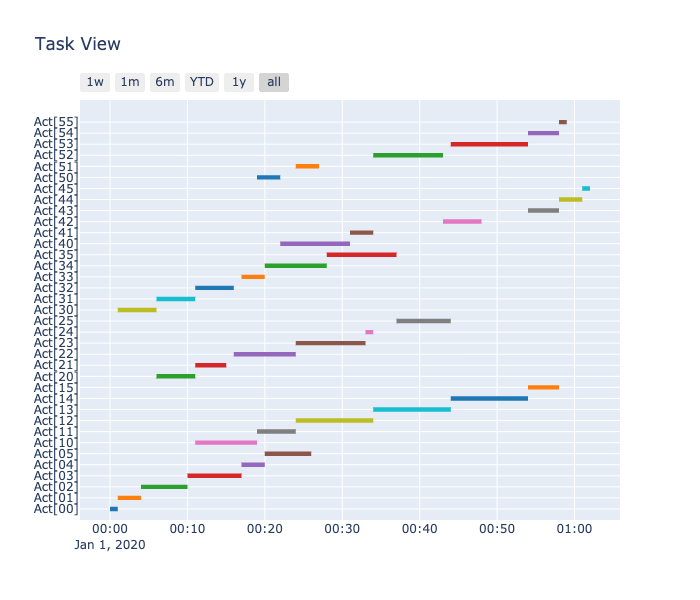

In [ ]:
model = ex15("data/optseq/ft06.txt")
model.Params.TimeLimit = 10
model.optimize()
if model.Status >=0:
    #model.write(folder +"chart15.txt")
    pass
fig = make_gannt(model, start = "2020/01/01", period ="minutes")
#plotly.offline.plot(fig);
Image("figure/ex15.png")

#### 例題16: 後ろ詰めの表現方法

例題６の納期遅れ最小化問題において， 作業1の納期を15とし，後ろ詰めで最適化を行う．


In [ ]:
#export
def ex16():
    """
    Example 16
    Minimizing the Tardiness
    file name: Example16.py
    Copyright Log Opt Co., Ltd.

    Consider a 4-activity problem with one machine resource.
    The due dates and processing times (durations) of the activities are kept in the dictionaries
     due={1:15,2:9,3:6,4:4} and
     duration={1:1, 2:2, 3:3, 4:4 }, respectively.
    We have to pay tardiness penalty by the amount the completion time of the activity exceeds its due date.
    The objective is to find the schedule that minimizes total tardiness penalty cost.

    But the activity 1 shoud be dispatched as late as possible!
    """

    m1=Model()
    due={1:15,2:9,3:6,4:4}
    duration={1:1, 2:2, 3:3, 4:4 }

    res=m1.addResource("writer")
    res.addCapacity(0,"inf",1)

    act={}
    mode={}

    for i in duration:
        if i==1:
            act[i]=m1.addActivity("Act[{0}]".format(i), duedate=due[i], backward=True)
        else:
            act[i]=m1.addActivity("Act[{0}]".format(i), duedate=due[i])
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,{(0,"inf"):1})
        act[i].addModes(mode[i])

    m1.addTemporal(act[4],act[1])

    m1.Params.TimeLimit=1
    m1.Params.OutputFlag=True
    m1.Params.Makespan=False
    return m1

In [ ]:
model = ex16()
model.optimize()
print(model)
#model.write(folder +"chart16.txt")


 ================ Now solving the problem ================ 


output:
# reading data ... done: 0.00(s)
# random seed: 1
# tabu tenure: 1
# cpu time limit: 1.00(s)
# iteration limit: 1073741823
# computing all-pairs longest paths and strongly connected components ... done
#scc 6
objective value = 1 (cpu time = 0.00(s), iteration = 0)
0: 0.00(s): 1/1

--- best solution ---
source,---, 0 0
sink,---, 15 15
Act[1],---, 14 14--15 15
Act[2],---, 7 7--9 9
Act[3],---, 4 4--7 7
Act[4],---, 0 0--4 4
--- tardy activity ---
Act[3]: 1
--- resource residuals ---
writer: [0,9] 0 [9,14] 1 [14,15] 0 

--- best activity list ---
source ---
Act[4] ---
Act[3] ---
Act[2] ---
Act[1] ---
sink ---

objective value = 1
cpu time = 0.00/1.00(s)
iteration = 0/56828


Solutions:
    source   ---     0     0
      sink   ---    15    15
    Act[1]   ---    14    15
    Act[2]   ---     7     9
    Act[3]   ---     4     7
    Act[4]   ---     0     4
Model:
number of activities= 4
number of resources= 1

Resource I

#### 練習問題 1：楽観値と悲観値


以下の表のような作業に対して，問いに答えよ．

<div style="text-align: left;">
表：先行作業と作業時間（楽観値，平均値，悲観値）
</div>

| 作業名 |  先行作業| 楽観値 | 平均値 |  悲観値 |   
|  ---- | ----   | ----   |----  |  ----   |
|   A   |   なし  |    1   |    2 |     3   |                
|   B   |   なし  |    2   |    3 |     4   |   
|   C   |    A   |    1   |   2  |     3   |                        
|   D   |    B   |    2   |   4  |     6   |              
|   E   |     C  |    1   |   4  |     7   |                   
|   F   |    C   |    1   |   2  |     3   |                         
|  G    |   D,E  |    3   |   4  |     5   |                
| H     |   F,G  |    1   |   2  |     3   |       
 
 
 
- 作業時間の楽観値に対して作業 H が完了する最早時刻を求めよ．
- 作業時間の平均値に対して作業 H が完了する最早時刻を求めよ．
- 作業時間の悲観値に対して作業 H が完了する最早時刻を求めよ．
- 作業時間が楽観値と悲観値の間の一様分布と仮定したときの，作業 H が完了する最早時刻の分布をmatplotlibを用いて描け．


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---     8     8
    Act[A]   ---     0     1
    Act[B]   ---     0     2
    Act[C]   ---     1     2
    Act[D]   ---     2     4
    Act[E]   ---     2     3
    Act[F]   ---     2     3
    Act[G]   ---     4     7
    Act[H]   ---     7     8
8

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    14    14
    Act[A]   ---     0     2
    Act[B]   ---     0     3
    Act[C]   ---     2     4
    Act[D]   ---     3     7
    Act[E]   ---     4     8
    Act[F]   ---     4     6
    Act[G]   ---     8    12
    Act[H]   ---    12    14
14

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    21    21
    Act[A]   ---     0     3
    Act[B]   ---     0     4
    Act[C]   ---     3     6
    Act[D]   ---     4    10
    Act[E]   ---   

(array([1., 0., 0., 0., 0., 0., 1., 0., 1., 1.]),
 array([11. , 11.6, 12.2, 12.8, 13.4, 14. , 14.6, 15.2, 15.8, 16.4, 17. ]),
 <BarContainer object of 10 artists>)

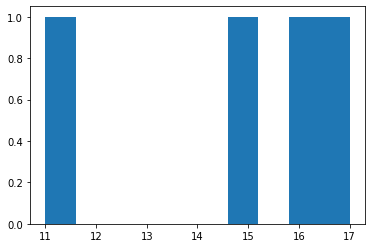

In [ ]:
#hide
#from optseq import *
JobInfo ={"A": (1,2,3), "B": (2,3,4), "C":  (1,2,3), "D": (2,4,6), "E": (1,4,7),
          "F": (1,2,3), "G":(3,4,5), "H": (1,2,3) }
Pred    ={"A":  [], "B": [], "C":  ["A"], "D": ["B"], "E": ["C"],
          "F":  ["C"], "G":["D","E"], "H": ["F","G"] }               
duration ={1:10, 2:20, 3:10, 4:25, 5:22 }

for j in range(3):    
    m1=Model() 
    act={}
    mode={}
    for i in JobInfo: 
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i),JobInfo[i][j])
        act[i].addModes(mode[i])
        
    for i in JobInfo:
        for p in Pred[i]:
            m1.addTemporal(act[p],act[i])
    
    m1.Params.TimeLimit=1
    m1.Params.Makespan =True
    m1.optimize()
    print(act["H"].completion)

# simulation
%matplotlib inline
import matplotlib.pyplot as plt
import random
data=[]
#for n in range(100):
for n in range(4):
    m1=Model() 
    act={}
    mode={}
    for i in JobInfo: 
        act[i]=m1.addActivity("Act[{0}]".format(i))
        mode[i]=Mode("Mode[{0}]".format(i), random.randint(JobInfo[i][0],JobInfo[i][2]) )
        act[i].addModes(mode[i])
        
    for i in JobInfo:
        for p in Pred[i]:
            m1.addTemporal(act[p],act[i])
    
    m1.Params.TimeLimit=1
    m1.Params.Makespan =True
    m1.OutputFlag=False
    m1.optimize()
    data.append( act["H"].completion) 

print(data)  
plt.hist(data)

#### 練習問題 2：並列ショップ（改）

例題3の並列ショップスケジューリングの例題に対して，以下のような変更を行ったときのスケジュールを求めよ．

1. 作業員4人で作業を行うとした場合
2. 作業間の時間制約をなくしたと仮定した場合
3. 作業時間をすべて $1$秒短縮したと仮定した場合


In [ ]:
Question_Number = 1 #ここを変える
m1=Model()
duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }
if Question_Number ==3:
    for d in duration:
        duration[d] -=1
if Question_Number ==1:
    res=m1.addResource("worker",capacity=4)
else:
    res=m1.addResource("worker",capacity=3)

act={}
mode={}

for i in duration:
    act[i]=m1.addActivity("Act[{0}]".format(i))
    if i==1:
        mode[1,1]=Mode("Mode[1_1]",3)
        mode[1,1].addResource(res,1)
        mode[1,2]=Mode("Mode[1_2]",2)
        mode[1,2].addResource(res,2)
        mode[1,3]=Mode("Mode[1_3]",1)
        mode[1,3].addResource(res,3)
        act[i].addModes(mode[1,1],mode[1,2],mode[1,3])
    else:
        mode[i]=Mode("Mode[{0}]".format(i),duration[i])
        mode[i].addResource(res,1)
        act[i].addModes(mode[i])
#temporal (precedense) constraints
if Question_Number ==2:
    pass
else:
    m1.addTemporal(act[1],act[9])
    for i in range(5,9):
        m1.addTemporal(act[4],act[i])
        m1.addTemporal(act[i],act[10])

m1.Params.TimeLimit=1
m1.Params.Makespan=True
m1.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    12    12
    Act[1] Mode[1_3]     0     1
    Act[2]   ---     1     3
    Act[3]   ---     1     3
    Act[4]   ---     0     2
    Act[5]   ---     2     6
    Act[6]   ---     3     7
    Act[7]   ---     3     7
    Act[8]   ---     6    10
    Act[9]   ---     1    12
   Act[10]   ---    10    12


#### 練習問題 3：お家を造ろう（改）

例題5の資源制約付きスケジューリングの例題に対して，
2階を建てる作業（作業時間は2人で2日）と，
2階の内装を行う作業（作業時間は1人で2日）追加した場合のスケジュールを求めよ．
ただし，2階を建てる作業は，1階の壁を取り付けた後でないと開始できず，
屋根の取り付けと2階の内装は，2階を建てた後でないと開始できないものと仮定する．

In [ ]:
#hide
m1=Model()                
duration ={1:1,2:3,3:2,4:2,5:2,6:2}
req={}
req[1]={(0,1):2 }
req[2]={(0,1):2 ,(1,3):1}
req[3]={(0,2):1 }
req[4]={(0,1):1,(1,2):2 }
req[5]={(0,2):2 }
req[6]={(0,2):1 }

res=m1.addResource("worker")
res.addCapacity(0,2,2)
res.addCapacity(2,3,1)
res.addCapacity(3,"inf",2)

act={}
mode={}

for i in duration: 
    act[i]=m1.addActivity("Act[{0}]".format(i))
    mode[i]=Mode("Mode[{0}]".format(i),duration[i])
    mode[i].addResource(res,requirement=req[i])
    act[i].addModes(mode[i])                                            

#temporal (precedense) constraints
m1.addTemporal(act[1],act[2])
m1.addTemporal(act[1],act[3])
m1.addTemporal(act[2],act[5])
m1.addTemporal(act[5],act[4])
m1.addTemporal(act[5],act[6])
m1.Params.TimeLimit=1
m1.Params.Makespan=True
m1.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    10    10
    Act[1]   ---     0     1
    Act[2]   ---     1     4
    Act[3]   ---     6     8
    Act[4]   ---     8    10
    Act[5]   ---     4     6
    Act[6]   ---     6     8


#### 練習問題 4：クリティカルパス法

例題７で，作業時間と短縮したときの費用が，以下のように設定されている場合を考え，予算が $0$ から $10$万円に
変化したときの最早完了時刻を求めよ．

- 作業1： 乗客降ろし $13$ 分．$12$ 分に短縮可能で，$1$ 万円必要．$11$ 分に短縮するには，さらに $1$ 万円必要．
- 作業2： 荷物降ろし $25$ 分．$23$ 分に短縮可能で，$1$ 万円必要．$21$ 分に短縮するには，さらに $1$ 万円必要．
- 作業3： 機内清掃 $15$ 分．$13$ 分に短縮可能で， $1$ 万円必要．$11$ 分に短縮するには，さらに $1$ 万円必要．
- 作業4： 新しい乗客の搭乗 $27$ 分．$26$ 分に短縮可能で， $1$ 万円必要．$25$ 分に短縮するには，さらに $1$ 万円必要．
- 作業5： 新しい荷物の積み込み $22$ 分．$21$ 分に短縮可能で，$1$ 万円必要．$20$ 分に短縮するには，さらに $1$ 万円必要．


In [ ]:
#hide
m1=Model()
Jobs=[1,2,3,4,5]
durationA = {1:13, 2:25, 3:15, 4:27, 5:22 }
durationB = {1:12, 2:23, 3:13, 4:26, 5:21 }
durationC = {1:11, 2:21, 3:11, 4:25, 5:20 }

act={}
mode={}
for i in Jobs:
    mode[i,1]=Mode("Mode[{0}][1]".format(i),durationA[i])
    mode[i,2]=Mode("Mode[{0}][2]".format(i),durationB[i])
    mode[i,3]=Mode("Mode[{0}][3]".format(i),durationC[i])
    act[i]=m1.addActivity("Act[{0}] ".format(i))
    act[i].addModes(mode[i,1],mode[i,2],mode[i,3])

res=m1.addResource("money",rhs=10,direction="<=")
    
for i in Jobs:
    res.addTerms(1,act[i],mode[i,2])
    res.addTerms(2,act[i],mode[i,3])

#temporal (precedense) constraints
m1.addTemporal(act[1],act[3])
m1.addTemporal(act[2],act[4])
m1.addTemporal(act[2],act[5])
m1.addTemporal(act[3],act[4])

m1.Params.TimeLimit=1
m1.Params.Makespan=True

#for i in range(11):
for i in range(2):
    res.rhs=i
    print("Budget=",i)
    m1.optimize()

Budget= 0

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    55    55
   Act[1]_ Mode[1][1]     0    13
   Act[2]_ Mode[2][1]     0    25
   Act[3]_ Mode[3][1]    13    28
   Act[4]_ Mode[4][1]    28    55
   Act[5]_ Mode[5][1]    25    47
Budget= 1

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    53    53
   Act[1]_ Mode[1][1]     0    13
   Act[2]_ Mode[2][1]     0    25
   Act[3]_ Mode[3][2]    13    26
   Act[4]_ Mode[4][1]    26    53
   Act[5]_ Mode[5][1]    25    47


#### 練習問題 5： 重み付き納期遅れ和

あなたは6つの異なる得意先から製品の製造を依頼された製造部長だ．
製品の製造は特注であり，それぞれ $1,4,2,3,1,4$ 日の製造日数がかかる．
ただし，製品の製造に必要な材料の到着する日は，それぞれ $4,0,2,4,1,5$ 日後と決まっている．
得意先には上得意とそうでもないものが混在しており，それぞれの重要度は
$3,1,2,3,1,2$ と推定されている．製品が完成する日数に重みを乗じたものの和を
なるべく小さくするように社長に命令されているが，さてどのような順序で
製品を製造したら良いのだろう？

In [ ]:
#hide
m1=Model()                
duration = {1:1, 2:4, 3:2, 4:3, 5:1, 6:4}
release = {1:4, 2:0, 3:2, 4:4, 5:1, 6:5}
weight = {1:3, 2:1, 3:2, 4:3, 5:1, 6:2}

res=m1.addResource("machine")
res.addCapacity(0,"inf",1)

act={}
mode={}
for i in duration: 
    act[i]=m1.addActivity(f"Act[{i}]",duedate=0, weight=weight[i])
    mode[i]=Mode(f"Mode[{i}]", duration[i])
    mode[i].addResource(res,{(0,"inf"):1})
    act[i].addModes(mode[i])
    m1.addTemporal('source', act[i], delay=release[i])

m1.Params.TimeLimit=1
m1.Params.Makespan=False
m1.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    16    16
    Act[1]   ---     4     5
    Act[2]   ---    12    16
    Act[3]   ---     2     4
    Act[4]   ---     5     8
    Act[5]   ---     1     2
    Act[6]   ---     8    12


#### 練習問題 6： 途中中断と並列処理

例題3の並列ショップスケジューリングに対して，以下のような変更を行ったときのスケジュールを求めよ．

1. すべての作業が途中中断可能と仮定した場合
2. すべての作業が並列処理可能と仮定した場合


In [ ]:
#hide
m1=Model()
duration ={1:3, 2:2, 3:2, 4:2, 5:4, 6:4, 7:4, 8:4, 9:11, 10:2 }

res=m1.addResource("worker")
res.addCapacity(0,"inf",3)

act={}
mode={}

for i in duration:
    act[i]=m1.addActivity("Act[{0}]".format(i))
    mode[i]=Mode("Mode[{0}]".format(i),duration[i])
    mode[i].addResource(res,1)
    #mode[i].addBreak(0,"inf","inf")
    mode[i].addParallel(1,"inf","inf")
    act[i].addModes(mode[i])

#temporal (precedense) constraints
m1.addTemporal(act[1],act[9])
for i in range(5,9):
    m1.addTemporal(act[4],act[i])
    m1.addTemporal(act[i],act[10])

m1.Params.TimeLimit=1
m1.Params.Makespan=True
m1.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    13    13
    Act[1]   ---     6     7
    Act[2]   ---     0     1
    Act[3]   ---     1     2
    Act[4]   ---     0     2
    Act[5]   ---    10    12
    Act[6]   ---     4     6
    Act[7]   ---     3     5
    Act[8]   ---     2     4
    Act[9]   ---     7    11
   Act[10]   ---    12    13


#### 練習問題 7：日本食レストラン

あなたは日本食レストランのオーナーだ．
あなたは，明日の元旦に向けて，3人のお客様に特製おせち料理を出さなければならない．
この特製おせちは，3人の料理人の流れ作業によって作られる．
最初の料理人は包丁担当で，これは彼ならではのテクニックで材料を切り刻む．
2番目の料理人は煮込み担当で，3番目の料理人は飾り付け担当だ．
当然，流れ作業なので，切りの後に煮込み，煮込みの後に飾り付けが行われ，
作業の途中中断はできないものと仮定する．
それぞれの工程の作業時間は，以下の表のようになっている．
さて，どのようにしたらなるべく早く料理を終えることができるだろうか？


<div style="text-align: left;">
表：日本食レストランの例題（単位は時間）
</div>


| お客さんの番号 |  1 |    2  |  3 |  
|  ----  |  ---- | ---- | ---- | 
|包丁担当の作業時間    |  2  |  4  |   1  |  
|煮込み担当の作業時間   |  3 |   2 |    4 |  
|飾り付け担当の作業時間  | 1  |  3  |   1  | 





In [ ]:
#hide
#包丁，煮込み，飾り付けを0,1,2とする．
m1=Model()
duration ={(0,1):2, (0,2):4, (0,3):1, (1,1):3, (1,2):2, (1,3):4, (2,1):1, (2,2):3, (2,3):1}

res={}
for i in range(3):
    res[i] = m1.addResource(f"worker{i}")
    res[i].addCapacity(0,"inf",1)

act={}
mode={}
for i,j in duration:
    act[i,j] = m1.addActivity(f"Act[{i}{j}]") 
    mode[i,j] = Mode(f"Mode[{i}{j}]", duration[i,j])
    mode[i,j].addResource(res[i],1)
    act[i,j].addModes(mode[i,j])

#temporal (precedense) constraints
for i in range(3):
    for j in range(1,3):
        m1.addTemporal(act[i,j],act[i,j+1])
for j in range(1,4):
    for i in range(2):
        m1.addTemporal(act[i,j],act[i+1,j])

m1.Params.TimeLimit=1
m1.Params.Makespan=True
m1.optimize()


 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---    13    13
   Act[01]   ---     0     2
   Act[02]   ---     2     6
   Act[03]   ---     6     7
   Act[11]   ---     2     5
   Act[12]   ---     6     8
   Act[13]   ---     8    12
   Act[21]   ---     5     6
   Act[22]   ---     8    11
   Act[23]   ---    12    13


#### 練習問題8: フローショップスケジューリング問題のベンチマーク問題例

例題15のジョブショップスケジューリング問題において，
各ジョブのオペレーション数が機械の台数 $m$ と一致し，
各ジョブ $J_j$ のオペレーションが $O_{1j},O_{2j},\cdots,O_{mj}$ の順で処理されなけばならず，
かつ各オペレーションが処理される機械がすべて異なり，かつその順序が同一のとき，フローショップスケジューリング問題とよばれる．

OR-Lib.（http://people.brunel.ac.uk/~mastjjb/jeb/orlib/flowshopinfo.html) にあるベンチマーク問題例を読み込んで解け．

たとえば，Carlier 11x5 の問題例（ファイル名はcar1.txt)は，以下のようなデータである．

``` 
 11 5
 0 375 1  12 2 142 3 245 4 412
 0 632 1 452 2 758 3 278 4 398
 0  12 1 876 2 124 3 534 4 765
 0 460 1 542 2 523 3 120 4 499
 0 528 1 101 2 789 3 124 4 999
 0 796 1 245 2 632 3 375 4 123
 0 532 1 230 2 543 3 896 4 452
 0  14 1 124 2 214 3 543 4 785
 0 257 1 527 2 753 3 210 4 463
 0 896 1 896 2 214 3 258 4 259
 0 532 1 302 2 501 3 765 4 988
 ```

データの説明は以下の通り．

```
Each instance consists of a line of description, a line containing the 
number of jobs and the number of machines, and then one line for each job,
listing the machine number and processing time for each step of the job. 
The machines are numbered starting with 0.
```

In [ ]:
#hide
fname = "../data/optseq/car1.txt"
f = open(fname,"r")
lines = f.readlines()
f.close()
n, m = map(int, lines[0].split())
print("n,m=", n, m)

model = Model() 
act, mode, res = {}, {}, {}
for j in range(m):
    res[j] = model.addResource(f"machine[{j}]",capacity=1)

# prepare data as dic
machine, proc_time ={}, {}
for i in range(n):    
    L = list(map(int,lines[i+1].split()))
    for j in range(m):
        machine[i,j] = L[2*j]
        proc_time[i,j] = L[2*j+1]

for i,j in proc_time:
    act[i,j] = model.addActivity(f"Act[{i}{j}]")
    mode[i,j]=Mode(f"Mode[{i}{j}]", proc_time[i,j])
    mode[i,j].addResource(res[j],1)
    act[i,j].addModes(mode[i,j])

for i in range(n):
    for j in range(m-1):
        model.addTemporal(act[i,j],act[i,j+1])

model.Params.TimeLimit=1
model.Params.Makespan =True

model.optimize()   

n,m= 11 5

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---  7351  7351
   Act[00]   ---    26   401
   Act[01]   ---   401   413
   Act[02]   ---   413   555
   Act[03]   ---   555   800
   Act[04]   ---   800  1212
   Act[10]   ---  3506  4138
   Act[11]   ---  4138  4590
   Act[12]   ---  4590  5348
   Act[13]   ---  5348  5626
   Act[14]   ---  6571  6969
   Act[20]   ---    14    26
   Act[21]   ---  1819  2695
   Act[22]   ---  2727  2851
   Act[23]   ---  2851  3385
   Act[24]   ---  3850  4615
   Act[30]   ---  2514  2974
   Act[31]   ---  2974  3516
   Act[32]   ---  5348  5871
   Act[33]   ---  5871  5991
   Act[34]   ---  6072  6571
   Act[40]   ---  1190  1718
   Act[41]   ---  1718  1819
   Act[42]   ---  1938  2727
   Act[43]   ---  2727  2851
   Act[44]   ---  2851  3850
   Act[50]   ---  1718  2514
   Act[51]   ---  2695  2940
   Act[52]   ---  6144  6776
   Act[53]   ---  6776  7151
   Act[54]   --- 

#### 練習問題9: オープンショップスケジューリング問題のベンチマーク問題例

例題15のジョブショップスケジューリング問題において，各ジョブ $J_j$ のオペレーションが処理される機械がすべて異なり，
$J_j$ のオペレーション $O_{1j},O_{2j},\cdots,O_{mj}$ の処理順があらかじめ決められていないとき，オープンショップスケジューリング問題とよばれる．


http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/ordonnancement.html にあるベンチマーク問題例を読み込んで解け．

たとえば，最も小さい問題例（ファイル名はtail04.txt)は，以下のようなデータである．

``` 
number of jobs, number of machines, time seed, machine seed, upper bound, lower bound :
           4           4  1166510396   164000672         193         186
processing times :
 54 34 61  2
  9 15 89 70
 38 19 28 87
 95 34  7 29
 ```
 
 何故か下界より良い解を得てしまう．元の論文にバグがあるのかもしれない．

In [ ]:
#hide
fname = "../data/optseq/tai04.txt"
f = open(fname,"r")
lines = f.readlines()
f.close()
n, m,  time_seed, machine_seed, upper_bound, lower_bound = map(int, lines[1].split())
print("n,m=", n, m)

model = Model() 
act, mode, res = {}, {}, {}
for j in range(m):
    res[j] = model.addResource(f"machine[{j}]",capacity=1)

# prepare data as dic
proc_time ={}
for i in range(n):    
    L = list(map(int,lines[i+3].split()))
    for j in range(m):
        proc_time[i,j] = L[j]
        
for i,j in proc_time:
    act[i,j] = model.addActivity(f"Act[{i}{j}]")
    for k in range(m): 
        mode[i,j,k]= Mode(f"Mode[{i}{j}{k}]", proc_time[i,j])
        mode[i,j,k].addResource(res[k],1)
        act[i,j].addModes(mode[i,j,k])

non_renewal ={}
for i in range(n):
    for k in range(m):
        non_renewal[i,k] = model.addResource(f"constraint[{i}{k}]",rhs=1,direction="<=")
        for j in range(m):
            non_renewal[i,k].addTerms(1,act[i,j],mode[i,j,k])
            
            
model.Params.TimeLimit=1
model.Params.Makespan =True
model.optimize()

n,m= 4 4

 ================ Now solving the problem ================ 


Solutions:
    source   ---     0     0
      sink   ---   172   172
   Act[00] Mode[001]    29    83
   Act[01] Mode[012]   132   166
   Act[02] Mode[023]   102   163
   Act[03] Mode[030]     0     2
   Act[10] Mode[102]     0     9
   Act[11] Mode[113]    87   102
   Act[12] Mode[120]     2    91
   Act[13] Mode[131]   102   172
   Act[20] Mode[200]   125   163
   Act[21] Mode[211]    83   102
   Act[22] Mode[222]     9    37
   Act[23] Mode[233]     0    87
   Act[30] Mode[302]    37   132
   Act[31] Mode[310]    91   125
   Act[32] Mode[323]   163   170
   Act[33] Mode[331]     0    29
